In [10]:
'''
Step1a. Fetch 225 constituent metadata & hist daily close px data
Filter out equities with MIN_AVG_VOLUME < 1m shares
Metadata:
1. Ticker
2. Name
3. Sector
4. Industry
5. AvgVolume      Avg of all trading volumes between START_DATE & END_DATE
6. P/E            Trailing P/E ratio (last 12 months actual historical earnings, qrtly update) (different from forward P/E)
7. MarketCap      Uses most recent (point-in-time) marketcap # provided by YF (equity px * o/s shares)
'''
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import os
import time

text_tickers = """
4151 4502 4503 4506 4507 4519 4523 4568 4578 6479 6501 6503 6504 6506 6526 6594
6645 6674 6701 6702 6723 6724 6752 6753 6758 6762 6770 6841 6857 6861 6902 6920
6952 6954 6971 6976 6981 7735 7751 7752 8035 7201 7202 7203 7205 7211 7261 7267
7269 7270 7272 4543 4902 6146 7731 7733 7741 7762 4151 9432 9433 9434 9613 9984
5831 7186 8304 8306 8308 8309 8316 8331 8354 8411 8253 8591 8697 8601 8604 8630
8725 8750 8766 8795 1605 3401 3402 3405 3407 4004 4005 4021 4042 4043 4061 4063
4183 4188 4208 3861 3407 4452 4901 4911 6988 5101 5108 5201 5214 5233 5301 5332
5333 5401 5406 5411 3436 5706 5711 5713 5714 5801 5802 5803 2768 8001 8002 8015
8031 8053 8058 1721 1801 1802 1803 1808 1812 1925 1928 1963 5631 6103 6113 6273
6301 6302 6305 6326 6361 6367 6471 6472 6473 7004 7011 7012 7013 7832 7911 7912
7951 3289 8801 8802 8804 8830 9001 9005 9007 9008 9009 9020 9021 9022 9064 9147
9101 9104 9107 9201 9202 9501 9502 9503 9531 9532 1332 2002 2269 2282 2501 2502
2503 2801 2802 2871 2914 3086 3092 3099 3382 7453 8233 8252 8267 9843 9983 2413
2432 3659 4307 4324 4385 4661 4689 4704 4751 4755 6098 6178 6532 7974 9602 9735
9766
"""

TICKERS = [f"{ticker}.T" for ticker in text_tickers.split()]

START_DATE = "2023-01-01"
END_DATE = "2025-06-01"
MIN_AVG_VOLUME = 1e6               # 1 million shares
CHECKPOINT_FILE = "N225_checkpoint.pkl"
OUTPUT_FILE = "N225_combined_data.csv"

def fetch_with_retry(ticker, max_retries=3):
    for _ in range(max_retries):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=START_DATE, end=END_DATE)
            info = stock.info
            return hist, info
        except Exception as e:
            print(f"Retry {_+1}/{max_retries} for {ticker} | Error: {str(e)}")
            time.sleep(2)
    return None, None

def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        return pd.read_pickle(CHECKPOINT_FILE)
    return pd.DataFrame()

def process_tickers():
    master_data = []
    checkpoint = load_checkpoint()
    processed_tickers = set(checkpoint.index.get_level_values(0)) if not checkpoint.empty else set()
    
    for ticker in tqdm([t for t in TICKERS if t not in processed_tickers], desc="Downloading N225 Stocks"):
        hist, info = fetch_with_retry(ticker)
        
        if hist is not None and not hist.empty:
            avg_volume = hist['Volume'].mean()
            
            if avg_volume >= MIN_AVG_VOLUME:
                row = {
                    'Ticker': ticker,
                    'Name': info.get('shortName', ticker),
                    'Sector': info.get('sector', 'N/A'),
                    'Industry': info.get('industry', 'N/A'),  # Added Industry
                    'AvgVolume': avg_volume,
                    'P/E': info.get('trailingPE', None),
                    'MarketCap': info.get('marketCap', None),
                    **{f"Close_{d.date()}": p for d, p in hist['Close'].items()}}
                master_data.append(row)
                
                if len(master_data) % 5 == 0:
                    new_data = pd.DataFrame(master_data).set_index(['Ticker', 'Name'])
                    combined = pd.concat([checkpoint, new_data])
                    combined.to_pickle(CHECKPOINT_FILE)
    
    # Combine all data
    new_data = pd.DataFrame(master_data).set_index(['Ticker', 'Name'])
    final_df = pd.concat([checkpoint, new_data])
    
    # Cleanup checkpoint
    if os.path.exists(CHECKPOINT_FILE):
        os.remove(CHECKPOINT_FILE)
    
    return final_df.T  

if __name__ == "__main__":
    try:
        df = process_tickers()
        df.to_csv(OUTPUT_FILE)
        print(f"\nData saved to {OUTPUT_FILE}")
        print("\nSample Output:")
        print(df.iloc[:5, :5])
        
        # Enhanced sector/industry stats
        sector_counts = df.loc['Sector'].value_counts()
        industry_counts = df.loc['Industry'].value_counts()
        
        print("\n=== Sector Analysis ===")
        print(f"Total Sectors: {len(sector_counts)}")
        print("Sector Distribution:")
        print(sector_counts)
        
        print("\n=== Industry Analysis ===")
        print(f"Total Industries: {len(industry_counts)}")
        print("Top 20 Industries:")
        print(industry_counts.head(20))
        
        # Additional statistics
        print("\n=== Summary Statistics ===")
        print(f"Total Tickers Processed: {len(df.columns)}")
        print(f"Avg Market Cap: ${df.loc['MarketCap'].mean():,.2f}")
        print(f"Median P/E Ratio: {df.loc['P/E'].median():.2f}")
        print(f"Avg Daily Volume: {df.loc['AvgVolume'].mean():,.0f} shares")
        
    except KeyboardInterrupt:
        print("\nProcess interrupted. Run again to resume.")


Data saved to N225_combined_data.csv

Sample Output:
Ticker                           4151.T  \
Name                 KYOWA KIRIN CO LTD   
Sector                       Healthcare   
Industry   Drug Manufacturers - General   
AvgVolume                1131355.348048   
P/E                           24.198011   
MarketCap                 1235674202112   

Ticker                                       4502.T  \
Name                   TAKEDA PHARMACEUTICAL CO LTD   
Sector                                   Healthcare   
Industry   Drug Manufacturers - Specialty & Generic   
AvgVolume                            4251241.765705   
P/E                                       63.637722   
MarketCap                             6672180314112   

Ticker                           4503.T  \
Name                    ASTELLAS PHARMA   
Sector                       Healthcare   
Industry   Drug Manufacturers - General   
AvgVolume                6739087.945671   
P/E                             50.5849   


In [32]:
'''
Step1b. Create DFs
'''
import pandas as pd

def load_n225_data(file_path):
    df = pd.read_csv(file_path, header=None)
    tickers = df.iloc[0, 1:].tolist()
    metadata_labels = df.iloc[1:7, 0].tolist()
    
    # Create metadata DF 
    metadata_df = pd.DataFrame(df.iloc[1:7, 1:].values.T,           # Transpose to get tickers as rows
        columns=metadata_labels, index=tickers)
    metadata_df.index.name = 'Ticker'
    
    numeric_fields = ['AvgVolume', 'P/E', 'MarketCap']
    for field in numeric_fields:
        if field in metadata_df.columns:
            metadata_df[field] = pd.to_numeric(metadata_df[field], errors='coerce')
    
    prices = df.iloc[7:, 1:]
    date_str = df.iloc[7:, 0].str.replace('Close_', '')
    prices.index = pd.to_datetime(date_str)
    prices = prices.astype(float)
    prices.columns = tickers
    
    return metadata_df, prices

if __name__ == "__main__":
    metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
    
    print("=== METADATA (First 3 tickers) ===")
    print(metadata_df.head(3))
    
    print("\n=== PRICE DATA (First & Last 3 days) ===")
    print(prices_df.head(3))
    print(prices_df.tail(3))
    print("\n=== DATA SHAPES ===")
    print(f"Metadata shape: {metadata_df.shape}")
    print(f"Prices shape: {prices_df.shape}")

=== METADATA (First 3 tickers) ===
                                Name      Sector  \
Ticker                                             
4151.T            KYOWA KIRIN CO LTD  Healthcare   
4502.T  TAKEDA PHARMACEUTICAL CO LTD  Healthcare   
4503.T               ASTELLAS PHARMA  Healthcare   

                                        Industry     AvgVolume        P/E  \
Ticker                                                                      
4151.T              Drug Manufacturers - General  1.131355e+06  24.188595   
4502.T  Drug Manufacturers - Specialty & Generic  4.251242e+06  63.536400   
4503.T              Drug Manufacturers - General  6.739088e+06  50.353480   

            MarketCap  
Ticker                 
4151.T  1236459192320  
4502.T  6678427729920  
4503.T  2550025945088  

=== PRICE DATA (First & Last 3 days) ===
                 4151.T       4502.T       4503.T      4506.T       4507.T  \
0                                                                            


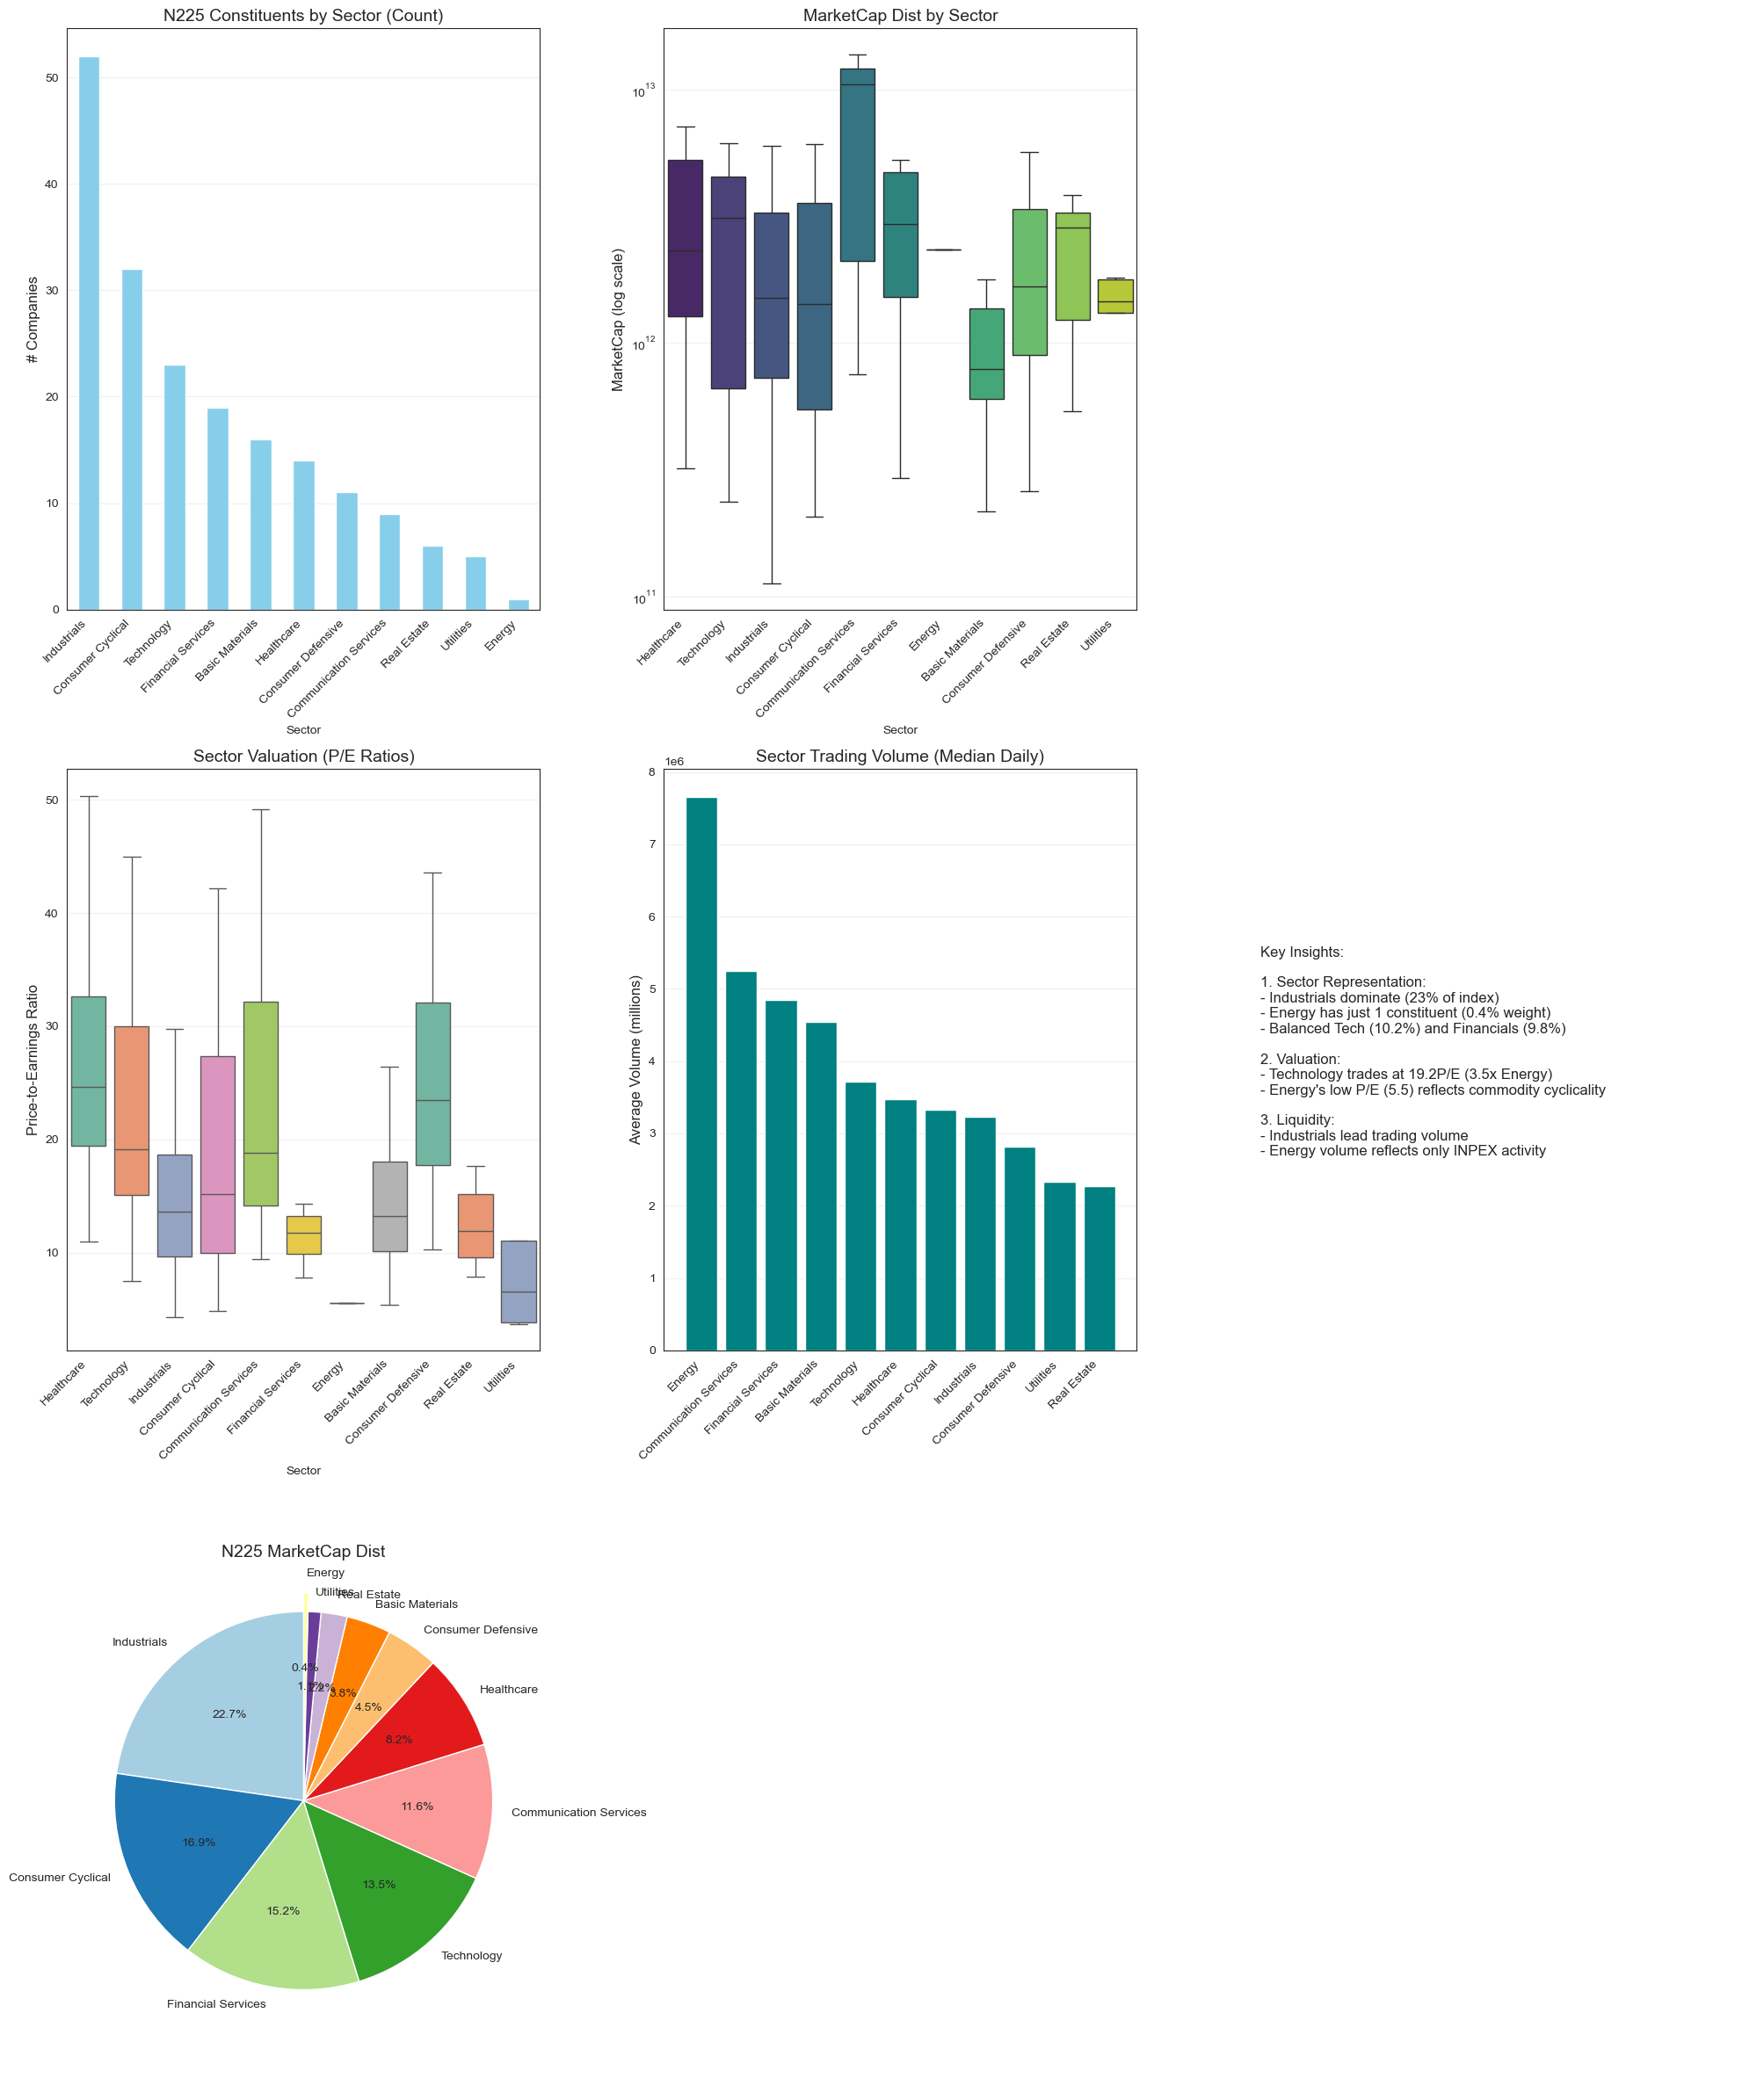

All charts and insights saved to 'n225_sector_analysis' directory:
- n225_sector_analysis/chart3_pe_ratios.png
- n225_sector_analysis/.DS_Store
- n225_sector_analysis/insights_textbox.png
- n225_sector_analysis/chart1_sector_distribution.png
- n225_sector_analysis/chart2_marketcap_distribution.png
- n225_sector_analysis/composite_analysis.png
- n225_sector_analysis/chart4_trading_volume.png
- n225_sector_analysis/chart5_marketcap_concentration.png


In [33]:
'''
Step1c. N225 Sector-related Charts
 '''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

output_dir = 'n225_sector_analysis'
os.makedirs(output_dir, exist_ok=True)

metadata = metadata_df.copy().reset_index()
price_data = prices_df.copy()

def robust_sector_agg(df, col):
    return df.groupby('Sector')[col].apply(
        lambda x: x.mean() if len(x)<3 else x.median())

sector_pe = metadata.dropna(subset=['P/E']).groupby('Sector')['P/E'].median().sort_values(ascending=False)
sector_mktcap_pct = (metadata.groupby('Sector')['MarketCap'].sum() / metadata['MarketCap'].sum() * 100).sort_values(ascending=False)
sector_volume = robust_sector_agg(metadata, 'AvgVolume').sort_values(ascending=False)
sector_counts = metadata['Sector'].value_counts()

def save_individual_charts():
    # Chart1: Sector Distribution
    plt.figure(figsize=(10, 6))
    sector_counts.plot(kind='bar', color='skyblue')
    plt.title('N225 Constituents by Sector (Count)', fontsize=14)
    plt.ylabel('# Companies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/chart1_sector_distribution.png', dpi=300)
    plt.close()

    # Chart2: MarketCap Distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metadata, x='Sector', y='MarketCap', palette='viridis', showfliers=False)
    plt.title('MarketCap Distribution by Sector', fontsize=14)
    plt.ylabel('MarketCap (log scale)', fontsize=12)
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/chart2_marketcap_distribution.png', dpi=300)
    plt.close()

    # Chart3: Sector P/E Ratios
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metadata.dropna(subset=['P/E']), x='Sector', y='P/E', palette='Set2', showfliers=False)
    plt.title('Sector Valuation (P/E Ratios)', fontsize=14)
    plt.ylabel('Price-to-Earnings Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/chart3_pe_ratios.png', dpi=300)
    plt.close()

    # Chart4: Sector Liquidity
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sector_volume.index, sector_volume, color='teal')
    plt.title('Sector Trading Volume (Median Daily)', fontsize=14)
    plt.ylabel('Average Volume (millions)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/chart4_trading_volume.png', dpi=300)
    plt.close()

    # Chart 5: Market Cap Concentration
    plt.figure(figsize=(10, 6))
    explode = [0.1 if sector == 'Energy' else 0 for sector in sector_mktcap_pct.index]
    sector_mktcap_pct.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode, colors=plt.cm.Paired.colors, textprops={'fontsize': 10})
    plt.title('N225 MarketCap Dist', fontsize=14)
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/chart5_marketcap_concentration.png', dpi=300)
    plt.close()

    # Insights Text Box
    insight_text = """Key Insights:

1. Sector Representation:
- Industrials dominate (23% of index)
- Energy has just 1 constituent (0.4% weight)
- Balanced Tech (10.2%) and Financials (9.8%)

2. Valuation:
- Technology trades at {tech_pe:.1f}P/E ({pe_ratio:.1f}x Energy)
- Energy's low P/E ({energy_pe:.1f}) reflects commodity cyclicality

3. Liquidity:
- Industrials lead trading volume
- Energy volume reflects only INPEX activity

""".format(tech_pe=sector_pe.get('Technology', np.nan), energy_pe=sector_pe.get('Energy', np.nan), pe_ratio=sector_pe.get('Technology', 1)/sector_pe.get('Energy', 1))
    plt.figure(figsize=(10, 6))
    plt.axis('off')
    plt.text(0.1, 0.5, insight_text, ha='left', va='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    plt.tight_layout()
    plt.savefig(f'{output_dir}/insights_textbox.png', dpi=300)
    plt.close()

# Generate and save individual charts
save_individual_charts()

# Create composite visualization
fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(3, 3)

# Chart 1
ax1 = fig.add_subplot(gs[0, 0])
sector_counts.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('N225 Constituents by Sector (Count)', fontsize=14)
ax1.set_ylabel('# Companies', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.get_xticklabels(), ha='right')
ax1.grid(axis='y', alpha=0.3)

# Chart 2
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=metadata, x='Sector', y='MarketCap', palette='viridis', showfliers=False, ax=ax2)
ax2.set_title('MarketCap Dist by Sector', fontsize=14)
ax2.set_ylabel('MarketCap (log scale)', fontsize=12)
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.get_xticklabels(), ha='right')
ax2.grid(axis='y', alpha=0.3)

# Chart 3
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=metadata.dropna(subset=['P/E']), x='Sector', y='P/E', palette='Set2', showfliers=False, ax=ax3)
ax3.set_title('Sector Valuation (P/E Ratios)', fontsize=14)
ax3.set_ylabel('Price-to-Earnings Ratio', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
plt.setp(ax3.get_xticklabels(), ha='right')
ax3.grid(axis='y', alpha=0.3)

# Chart 4
ax4 = fig.add_subplot(gs[1, 1])
bars = ax4.bar(sector_volume.index, sector_volume, color='teal')
ax4.set_title('Sector Trading Volume (Median Daily)', fontsize=14)
ax4.set_ylabel('Average Volume (millions)', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
plt.setp(ax4.get_xticklabels(), ha='right')
ax4.grid(axis='y', alpha=0.3)

# Chart 5
ax5 = fig.add_subplot(gs[2, 0])
explode = [0.1 if sector == 'Energy' else 0 for sector in sector_mktcap_pct.index]
sector_mktcap_pct.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode, colors=plt.cm.Paired.colors, textprops={'fontsize': 10}, ax=ax5)
ax5.set_title('N225 MarketCap Dist', fontsize=14)
ax5.set_ylabel('')

# Insights Panel
ax6 = fig.add_subplot(gs[:, 2])
ax6.axis('off')
insight_text = """Key Insights:

1. Sector Representation:
- Industrials dominate (23% of index)
- Energy has just 1 constituent (0.4% weight)
- Balanced Tech (10.2%) and Financials (9.8%)

2. Valuation:
- Technology trades at {tech_pe:.1f}P/E ({pe_ratio:.1f}x Energy)
- Energy's low P/E ({energy_pe:.1f}) reflects commodity cyclicality

3. Liquidity:
- Industrials lead trading volume
- Energy volume reflects only INPEX activity
""".format(
    tech_pe=sector_pe.get('Technology', np.nan),
    energy_pe=sector_pe.get('Energy', np.nan),
    pe_ratio=sector_pe.get('Technology', 1)/sector_pe.get('Energy', 1)
)

ax6.text(0, 0.5, insight_text, ha='left', va='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Add chart numbers
#for ax, chart_num in zip([ax1, ax2, ax3, ax4, ax5], range(1, 6)):
#    ax.annotate(f'Chart {chart_num}', xy=(0.02, 0.95), xycoords='axes fraction',
#               fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{output_dir}/composite_analysis.png', dpi=300)
plt.show()

print(f"All charts and insights saved to '{output_dir}' directory:")
print('\n'.join([f"- {output_dir}/{f}" for f in os.listdir(output_dir)]))

Displaying charts in notebook...


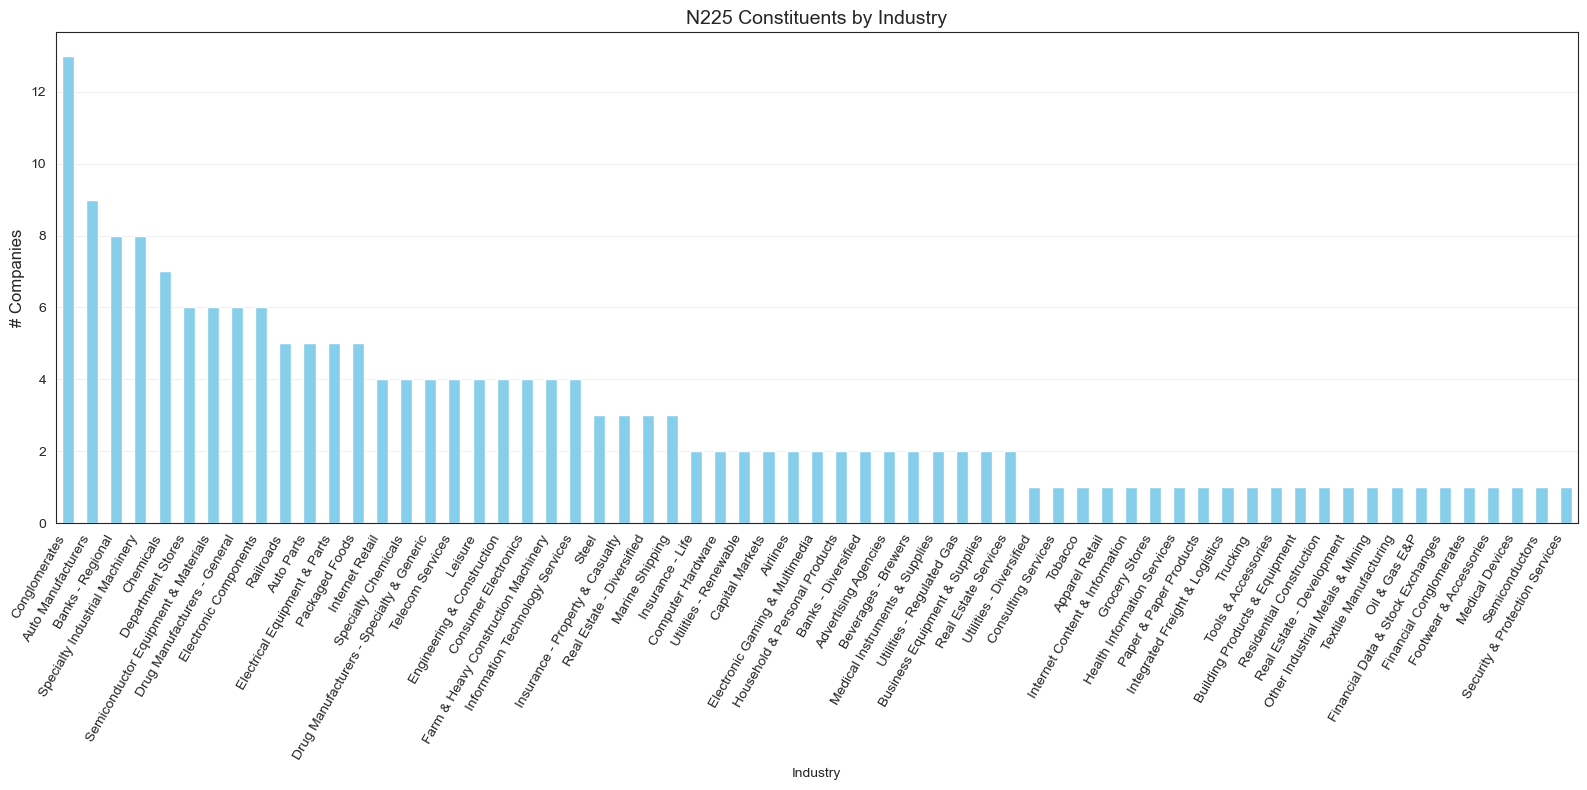

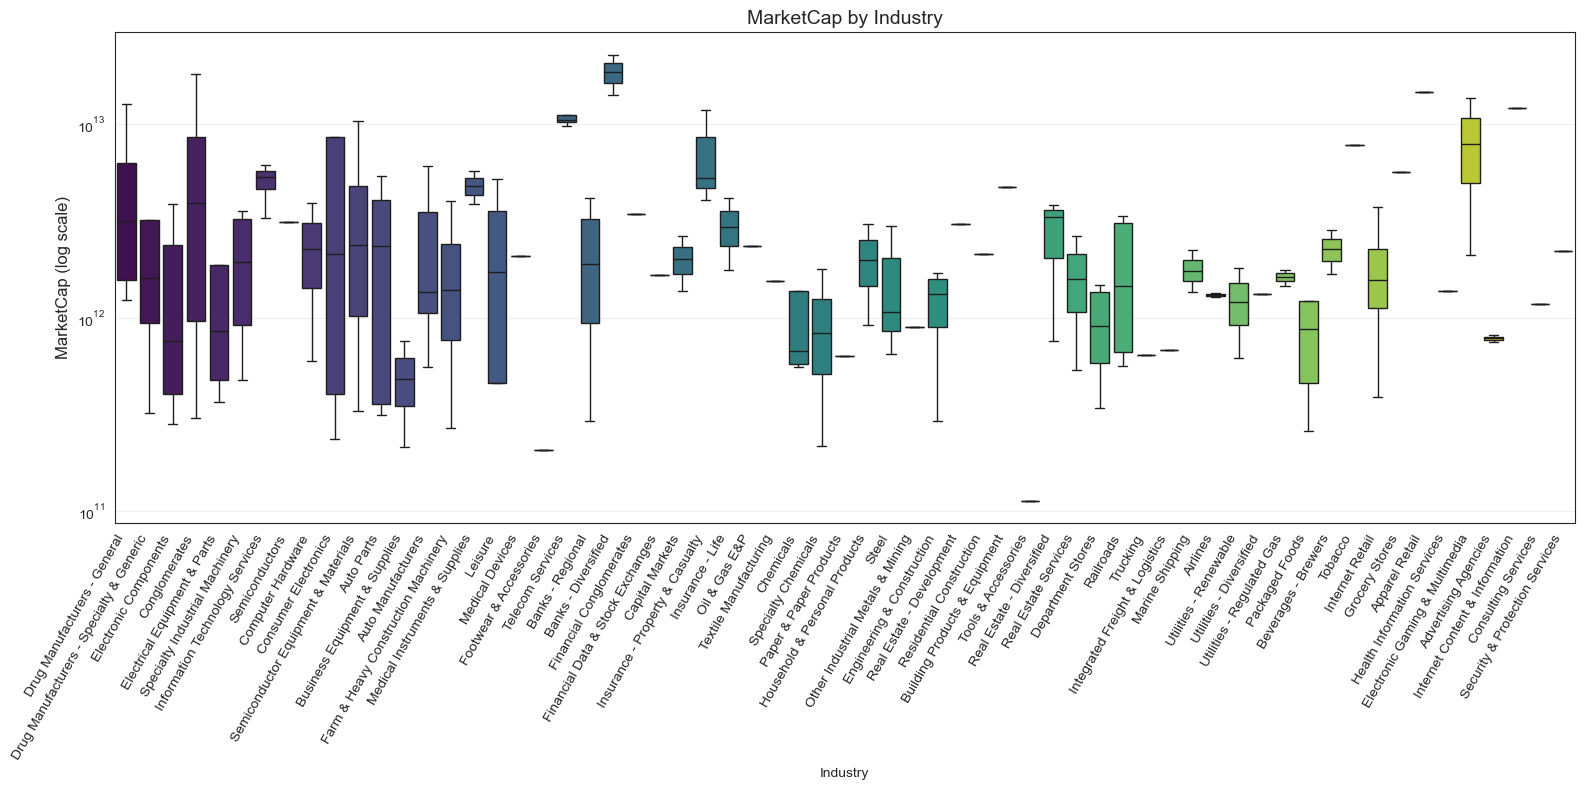

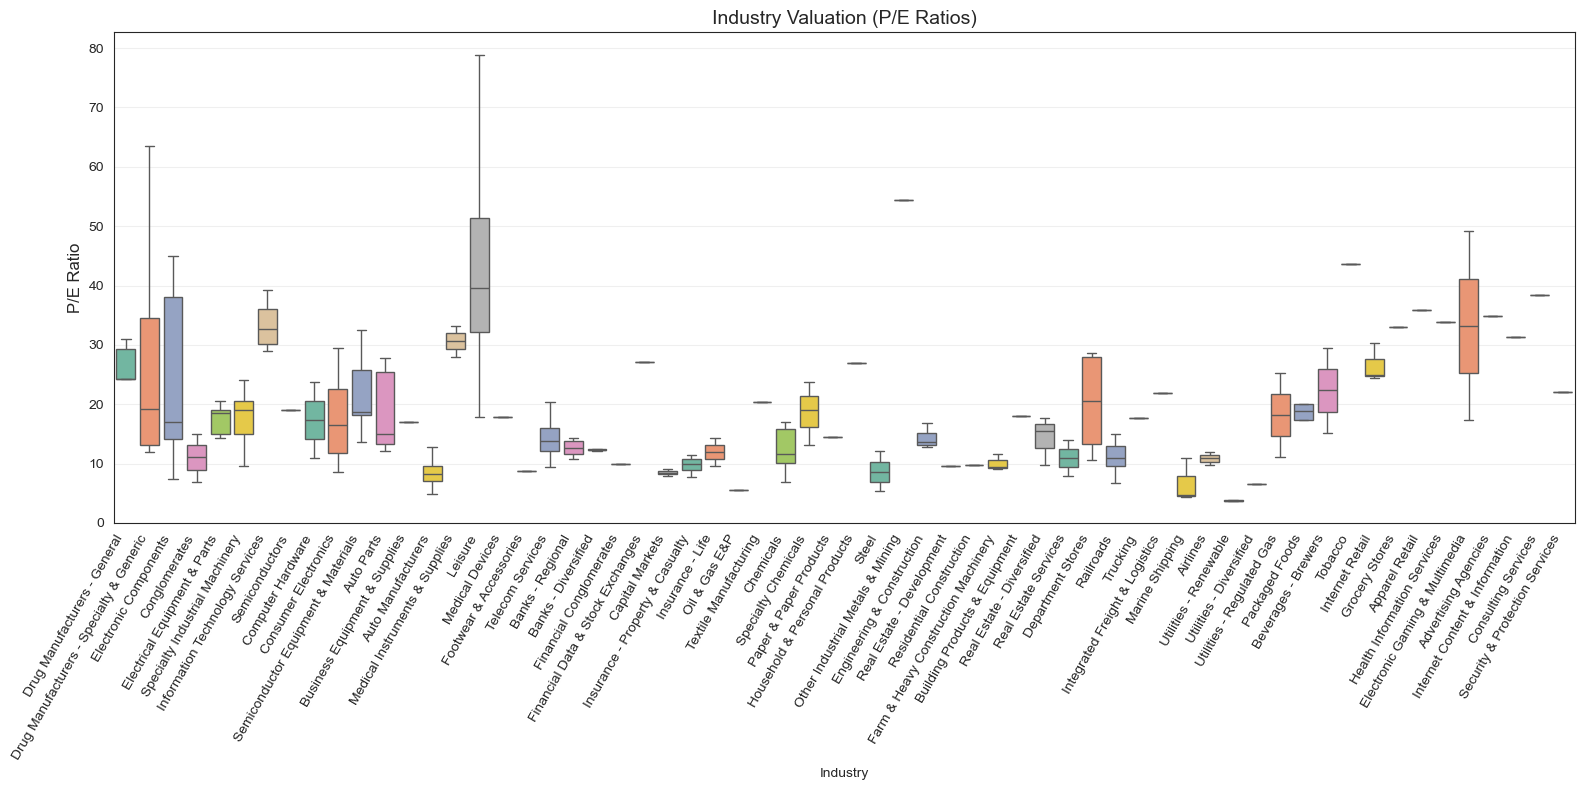

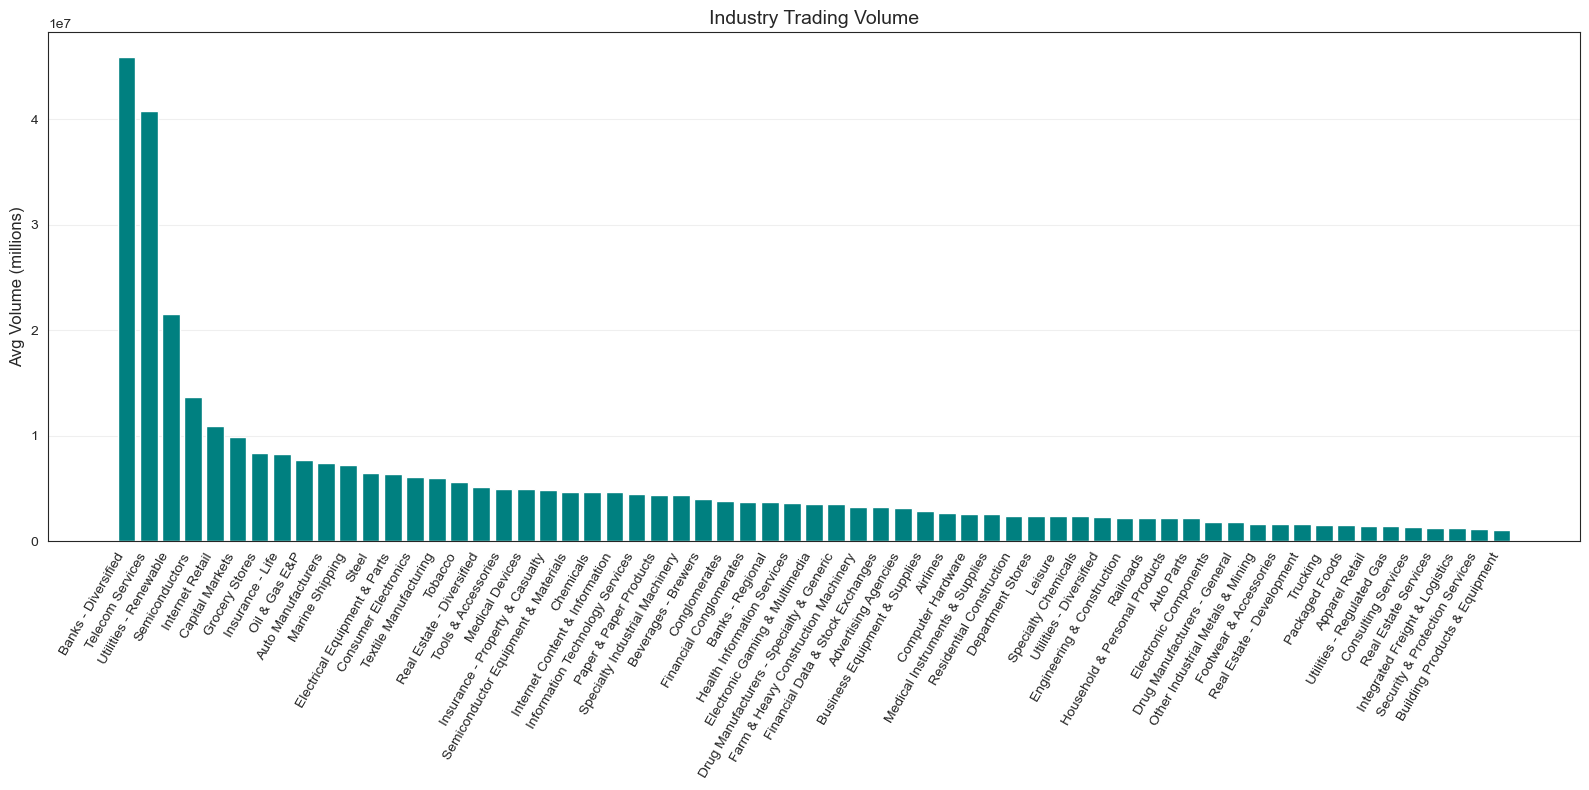

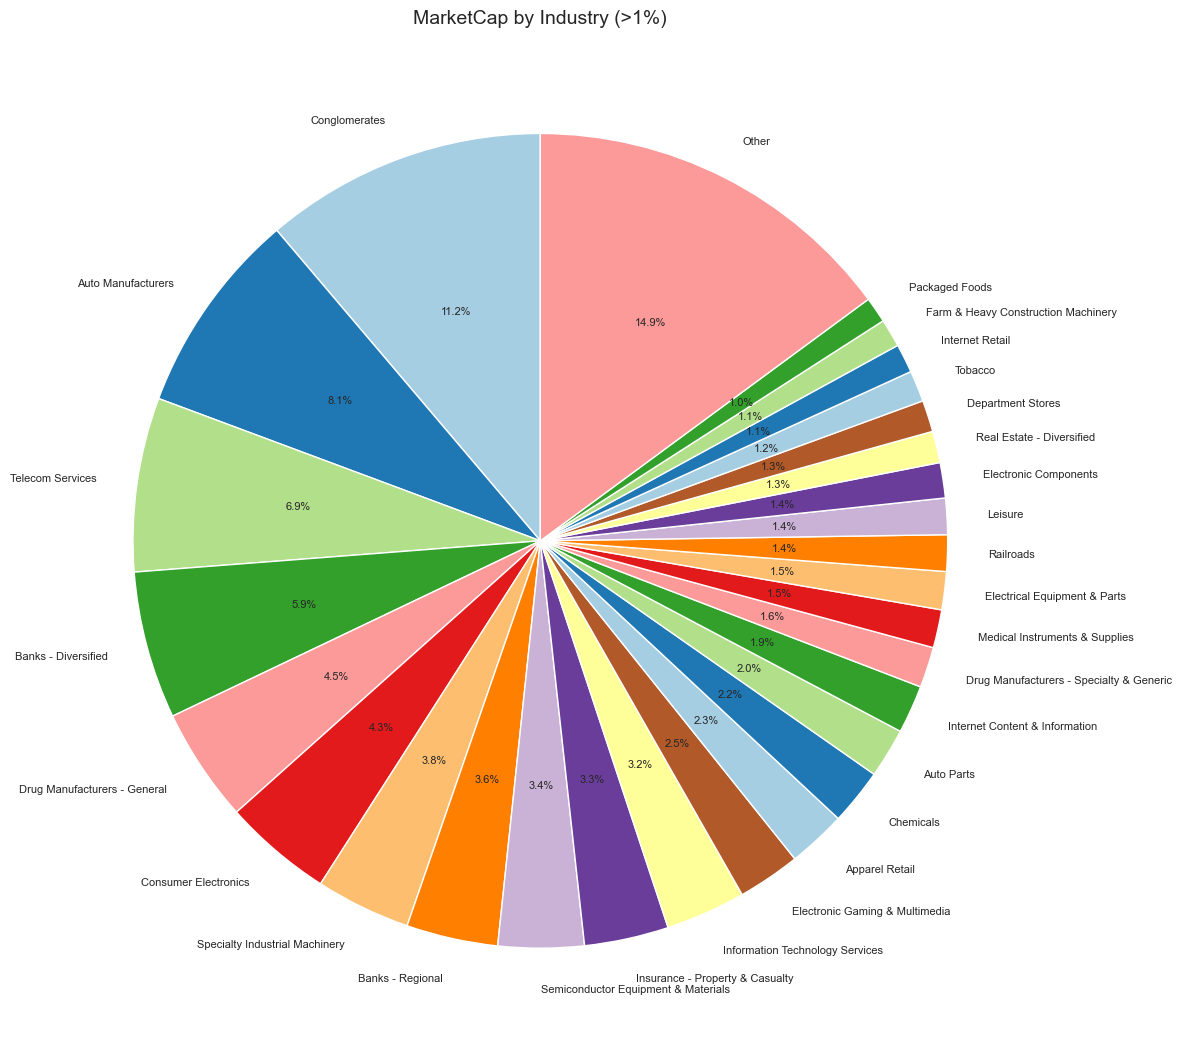

Key Insights:

1. Industry Representation:
- Top industry: Conglomerates (13 companies)
- 23 industries have just 1 constituent: Utilities - Diversified, Consulting Services, Tobacco, Apparel Retail, Internet Content & Information, Grocery Stores, Health Information Services, Paper & Paper Products, Integrated Freight & Logistics, Trucking, Tools & Accessories, Building Products & Equipment, Residential Construction, Real Estate - Development, Other Industrial Metals & Mining, Textile Manufacturing, Oil & Gas E&P, Financial Data & Stock Exchanges, Financial Conglomerates, Footwear & Accessories, Medical Devices, Semiconductors, Security & Protection Services

2. Valuation:
- Highest P/E: Other Industrial Metals & Mining (54.5)
- Lowest P/E: Utilities - Renewable (3.8)
- 14.4x difference between extremes

3. Liquidity:
- Most traded: Banks - Diversified (45.9M shares/day)
- Least traded: Building Products & Equipment (1.1M shares/day)

4. Market Concentration:
- Top 3 industries: Conglo

/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_59134/1161031119.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.savefig(f'{output_dir}/insights_textbox.png', dpi=300, bbox_inches='tight')



Analysis saved to 'n225_industry_analysis':
- chart1_industry_distribution.png
- chart2_marketcap_distribution.png
- chart3_pe_ratios.png
- chart4_trading_volume.png
- chart5_marketcap_concentration.png
- insights_textbox.png


In [34]:
'''
Step1d. N225 Industry Analysis
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 30 

output_dir = 'n225_industry_analysis'
os.makedirs(output_dir, exist_ok=True)
metadata = metadata_df.copy().reset_index()

def robust_industry_agg(df, col):
    return df.groupby('Industry')[col].apply(
        lambda x: x.mean() if len(x)<3 else x.median())

industry_pe = metadata.dropna(subset=['P/E']).groupby('Industry')['P/E'].median().sort_values(ascending=False)
industry_mktcap_pct = (metadata.groupby('Industry')['MarketCap'].sum() / metadata['MarketCap'].sum() * 100).sort_values(ascending=False)
industry_volume = robust_industry_agg(metadata, 'AvgVolume').sort_values(ascending=False)
industry_counts = metadata['Industry'].value_counts()

significant_industries = industry_mktcap_pct[industry_mktcap_pct > 1].copy()
significant_industries['Other'] = 100 - significant_industries.sum()
explode = [0.1 if x == 'Oil & Gas E&P' else 0 for x in significant_industries.index]

# Generate insights text
def generate_insights():
    single_company_industries = industry_counts[industry_counts == 1]
    single_company_list = ", ".join(single_company_industries.index.tolist())
    num_single_company = len(single_company_industries)
    
    return """Key Insights:

1. Industry Representation:
- Top industry: {top_industry} ({top_count} companies)
- {num_single} industries have just 1 constituent: {single_list}

2. Valuation:
- Highest P/E: {high_pe_industry} ({high_pe:.1f})
- Lowest P/E: {low_pe_industry} ({low_pe:.1f})
- {pe_ratio:.1f}x difference between extremes

3. Liquidity:
- Most traded: {high_vol_industry} ({high_vol:.1f}M shares/day)
- Least traded: {low_vol_industry} ({low_vol:.1f}M shares/day)

4. Market Concentration:
- Top 3 industries: {top3_industries}
- Account for {top3_percent:.1f}% of index value
""".format(
    top_industry=industry_counts.index[0],
    top_count=industry_counts.iloc[0],
    num_single=num_single_company,
    single_list=single_company_list,
    bottom_industry=industry_counts.index[-1],
    bottom_count=industry_counts.iloc[-1],
    high_pe_industry=industry_pe.index[0],
    high_pe=industry_pe.iloc[0],
    low_pe_industry=industry_pe.index[-1],
    low_pe=industry_pe.iloc[-1],
    pe_ratio=industry_pe.iloc[0]/industry_pe.iloc[-1],
    high_vol_industry=industry_volume.index[0],
    high_vol=industry_volume.iloc[0]/1e6,
    low_vol_industry=industry_volume.index[-1],
    low_vol=industry_volume.iloc[-1]/1e6,
    top3_industries=', '.join(industry_mktcap_pct.index[:3]),
    top3_percent=industry_mktcap_pct.iloc[:3].sum())

# Create and display charts
def create_and_display_charts():
    # Chart1: Industry Distribution
    plt.figure(figsize=(16, 8))
    industry_counts.plot(kind='bar', color='skyblue')
    plt.title('N225 Constituents by Industry', fontsize=14)
    plt.ylabel('# Companies', fontsize=12)
    plt.xticks(rotation=60, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Chart2: MarketCap Distribution
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=metadata, x='Industry', y='MarketCap', hue='Industry', palette='viridis', showfliers=False, legend=False)
    plt.title('MarketCap by Industry', fontsize=14)
    plt.ylabel('MarketCap (log scale)', fontsize=12)
    plt.yscale('log')
    plt.xticks(rotation=60, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Chart 3: P/E Ratios
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=metadata.dropna(subset=['P/E']), x='Industry', y='P/E', hue='Industry', palette='Set2', showfliers=False, legend=False)
    plt.title('Industry Valuation (P/E Ratios)', fontsize=14)
    plt.ylabel('P/E Ratio', fontsize=12)
    plt.xticks(rotation=60, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Chart 4: Trading Volume
    plt.figure(figsize=(16, 8))
    plt.bar(industry_volume.index, industry_volume, color='teal')
    plt.title('Industry Trading Volume', fontsize=14)
    plt.ylabel('Avg Volume (millions)', fontsize=12)
    plt.xticks(rotation=60, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Chart 5: Market Cap Concentration
    plt.figure(figsize=(12, 12))
    significant_industries.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode, colors=plt.cm.Paired.colors, textprops={'fontsize': 8})
    plt.title('MarketCap by Industry (>1%)', fontsize=14)
    plt.ylabel('')
    plt.show()
    
    # Insights Text
    print(generate_insights())

# Save charts without tight layout warnings
def save_charts():
    # Chart 1
    fig, ax = plt.subplots(figsize=(16, 8))
    industry_counts.plot(kind='bar', color='skyblue', ax=ax)
    ax.set(title='N225 Constituents by Industry', ylabel='# Companies')
    ax.tick_params(axis='x', rotation=60)
    plt.setp(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', alpha=0.3)
    fig.savefig(f'{output_dir}/chart1_industry_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Chart 2
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(data=metadata, x='Industry', y='MarketCap', hue='Industry', palette='viridis', showfliers=False, ax=ax, legend=False)
    ax.set(title='MarketCap by Industry', ylabel='MarketCap (log scale)')
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=60)
    plt.setp(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', alpha=0.3)
    fig.savefig(f'{output_dir}/chart2_marketcap_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Chart 3
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(data=metadata.dropna(subset=['P/E']), x='Industry', y='P/E', hue='Industry', palette='Set2', showfliers=False, ax=ax, legend=False)
    ax.set(title='Industry Valuation (P/E Ratios)', ylabel='P/E Ratio')
    ax.tick_params(axis='x', rotation=60)
    plt.setp(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', alpha=0.3)
    fig.savefig(f'{output_dir}/chart3_pe_ratios.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Chart 4
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(industry_volume.index, industry_volume, color='teal')
    ax.set(title='Industry Trading Volume', ylabel='Avg Volume (millions)')
    ax.tick_params(axis='x', rotation=60)
    plt.setp(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', alpha=0.3)
    fig.savefig(f'{output_dir}/chart4_trading_volume.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Chart 5
    fig, ax = plt.subplots(figsize=(12, 12))
    significant_industries.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode, colors=plt.cm.Paired.colors, textprops={'fontsize': 8}, ax=ax)
    ax.set(title='MarketCap by Industry (>1%)', ylabel='')
    fig.savefig(f'{output_dir}/chart5_marketcap_concentration.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Insights Text
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.text(0.1, 0.5, generate_insights(), ha='left', va='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    fig.savefig(f'{output_dir}/insights_textbox.png', dpi=300, bbox_inches='tight')
    plt.close()

# Execute all
print("Displaying charts in notebook...")
create_and_display_charts()

print("\nSaving charts to files...")
save_charts()

print(f"\nAnalysis saved to '{output_dir}':")
print('\n'.join([f"- {f}" for f in sorted(os.listdir(output_dir)) if not f.startswith('.')]))

In [35]:
'''
Step2ai. Strat 1/2. N225 Statarb - Brute Force Method  (ie. analysis restricted to firms in the same Industry)
Industry (63) was chosen over Sector (11) - albeit 23 of the 63 Industries just have 1 constituent & are thus n/a for statarb,
we believe the increased granularity of industry classication will compensate for Strat1.
Strategy allocates JPY 1,000,000 per pair
Implements 50/50 capital allocation between legs
'''
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.gridspec as gridspec  
from matplotlib import rcParams
import os
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()]
industries = metadata_df['Industry'].to_dict()

output_dir = "n225_strat1_brute_force"
os.makedirs(output_dir, exist_ok=True)

# Generate pairs by industry
industry_stocks = {}
for ticker, industry in industries.items():
    industry_stocks.setdefault(industry, []).append(ticker)
valid_industries = {k: v for k, v in industry_stocks.items() if len(v) >= 2}

# Cointegration testing
results = []
for industry, tickers in valid_industries.items():
    for ticker1, ticker2 in combinations(tickers, 2):
        try:
            price1 = prices_df[ticker1].iloc[-90:].dropna()
            price2 = prices_df[ticker2].iloc[-90:].dropna()
            common_dates = price1.index.intersection(price2.index)
            if len(common_dates) < 60:
                continue
            spread = price1[common_dates] - price2[common_dates]
            adf_result = adfuller(spread, autolag="AIC")
            test_stat, pvalue, _, _, critical_values, _ = adf_result
            corr, _ = pearsonr(price1[common_dates], price2[common_dates])
            coint_level = next((level for level, cv in critical_values.items() if test_stat < cv), None)
            results.append({'Industry': industry, 'Ticker1': ticker1, 'Name1': metadata_df.loc[ticker1, 'Name'],
                'Ticker2': ticker2, 'Name2': metadata_df.loc[ticker2, 'Name'],
                'ADF_Stat': test_stat, 'Cointegrated': coint_level, 'Corr': corr, 'DataPts': len(common_dates)})
        except Exception as e:
            continue

results_df = pd.DataFrame(results)
results_df['Score'] = results_df.apply(lambda x: (3 if x['Cointegrated']=='1%' else 2 if x['Cointegrated']=='5%' else 1 if x['Cointegrated']=='10%' else 0) + abs(x['Corr'])*2, axis=1)
top_pairs = results_df.sort_values('Score', ascending=False).head(5)

# Backtest
initial_capital = 1_000_000
transaction_cost = 0.0015
results = []
portfolios = []

for _, pair in top_pairs.iterrows():
    ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
    price1 = prices_df[ticker1].dropna()
    price2 = prices_df[ticker2].dropna()
    common_idx = price1.index.intersection(price2.index)
    p1, p2 = price1[common_idx], price2[common_idx]
    spread = p1 - p2
    mean_spread = spread.rolling(30).mean()
    std_spread = spread.rolling(30).std()
    zscore = (spread - mean_spread) / std_spread
    signals = pd.Series(0, index=zscore.index)
    signals[zscore > 2.0] = -1
    signals[zscore < -2.0] = 1
    signals[(zscore.abs() < 0.5)] = 0
    signals = signals.ffill().shift()
    capital = initial_capital
    position1, position2 = 0, 0
    portfolio = pd.DataFrame(index=common_idx, columns=['Value', 'Return', 'Position1', 'Position2', 'Cum'])
    for date in common_idx[30:]:
        current_signal = signals.loc[date]
        prev_signal = signals.shift(1).loc[date]
        if current_signal != prev_signal:
            if prev_signal != 0:
                capital += position1 * p1.loc[date] * (1 - transaction_cost)
                capital += position2 * p2.loc[date] * (1 - transaction_cost)
                position1, position2 = 0, 0
            if current_signal == 1:
                position1 = (capital/2) / p1.loc[date]
                position2 = -(capital/2) / p2.loc[date]
                capital -= abs(position1 * p1.loc[date] * transaction_cost)
                capital -= abs(position2 * p2.loc[date] * transaction_cost)
            elif current_signal == -1:
                position1 = -(capital/2) / p1.loc[date]
                position2 = (capital/2) / p2.loc[date]
                capital -= abs(position1 * p1.loc[date] * transaction_cost)
                capital -= abs(position2 * p2.loc[date] * transaction_cost)
        portfolio.loc[date, 'Value'] = capital + position1 * p1.loc[date] + position2 * p2.loc[date]
        portfolio.loc[date, ['Position1', 'Position2']] = position1, position2
    portfolio['Return'] = portfolio['Value'].pct_change()
    portfolio['Cumulative'] = (1 + portfolio['Return'].fillna(0)).cumprod() * initial_capital
    portfolios.append(portfolio)
    final_value = portfolio['Value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital
    max_drawdown = (portfolio['Value'].cummax() - portfolio['Value']).max() / initial_capital
    results.append({
        'Pair': f"{ticker1}/{ticker2}",
        'Industry': pair['Industry'],
        'Final_Value_JPY': final_value,
        'Total_Return': total_return,
        'Ann_Return': (1 + total_return)**(252/len(portfolio)) - 1,
        'Max_DD': max_drawdown,
        'Sharpe_Ratio': portfolio['Return'].mean() / portfolio['Return'].std() * np.sqrt(252),
        'Trades': (signals.diff() != 0).sum(),
        'Coint_Level': pair['Cointegrated'],
        'Corr': pair['Corr']})

# Save results for later visualization
results_df_save = pd.DataFrame(results)
results_df_save.to_csv(os.path.join(output_dir, 'n225_stat_arb_results.csv'), index=False)
with open(os.path.join(output_dir, 'n225_stat_arb_portfolios.pkl'), 'wb') as f:
    pickle.dump(portfolios, f)

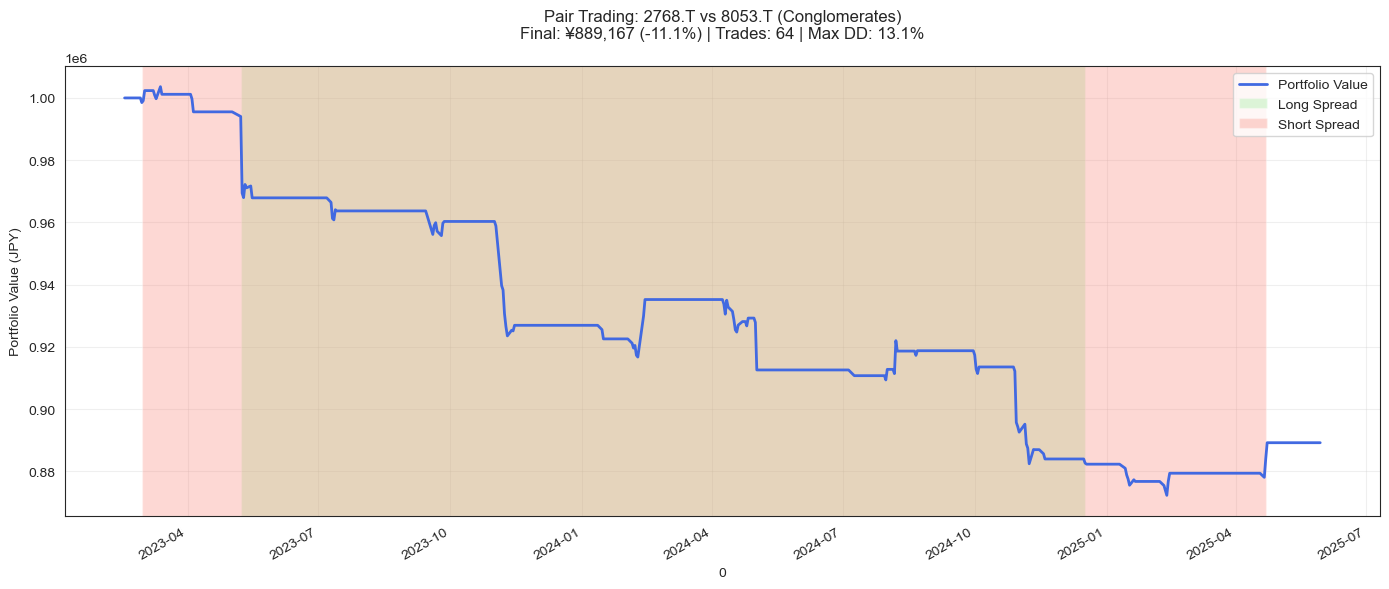

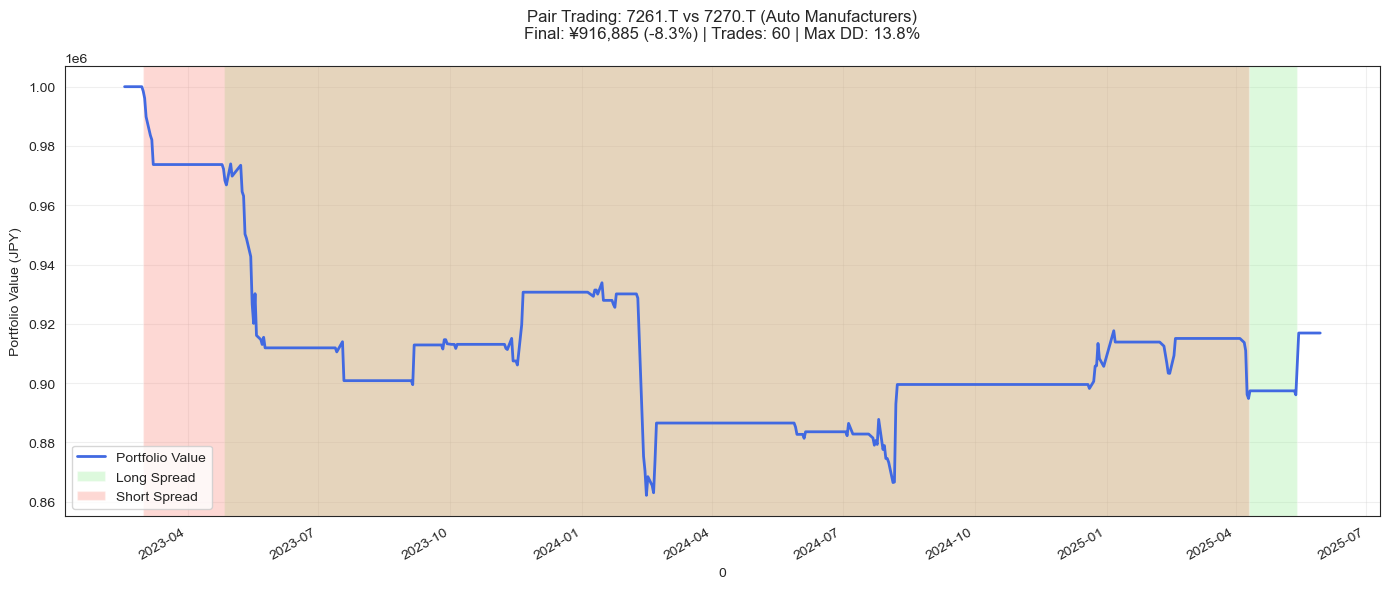

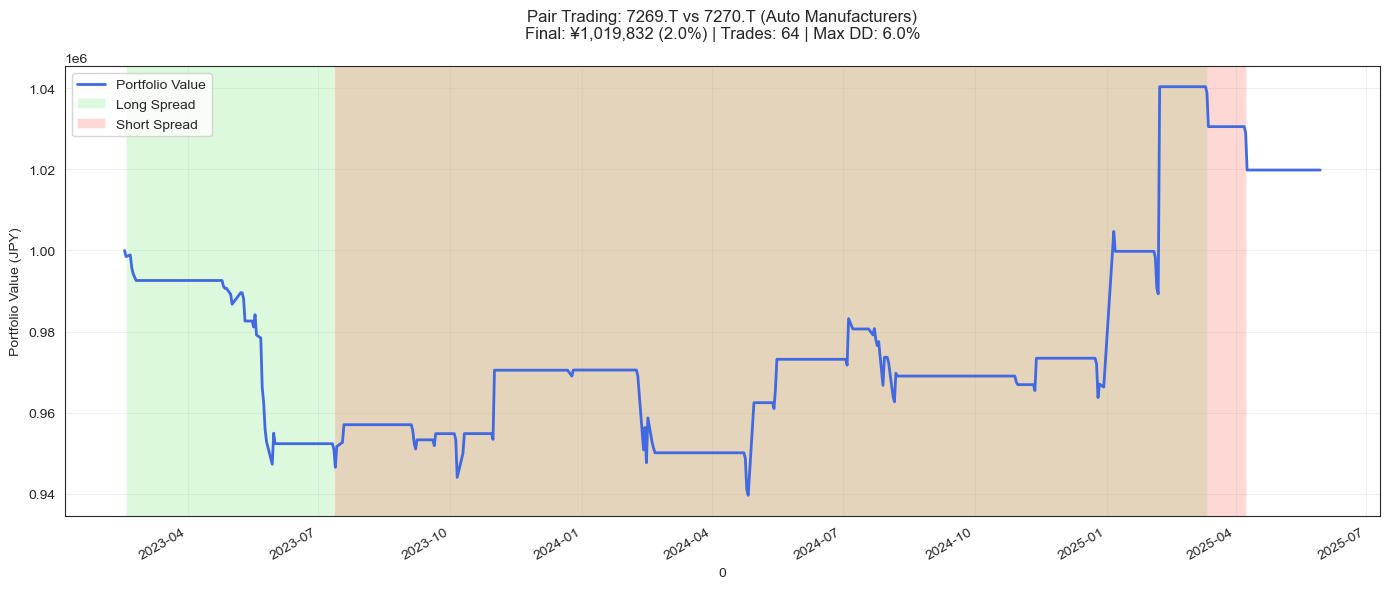

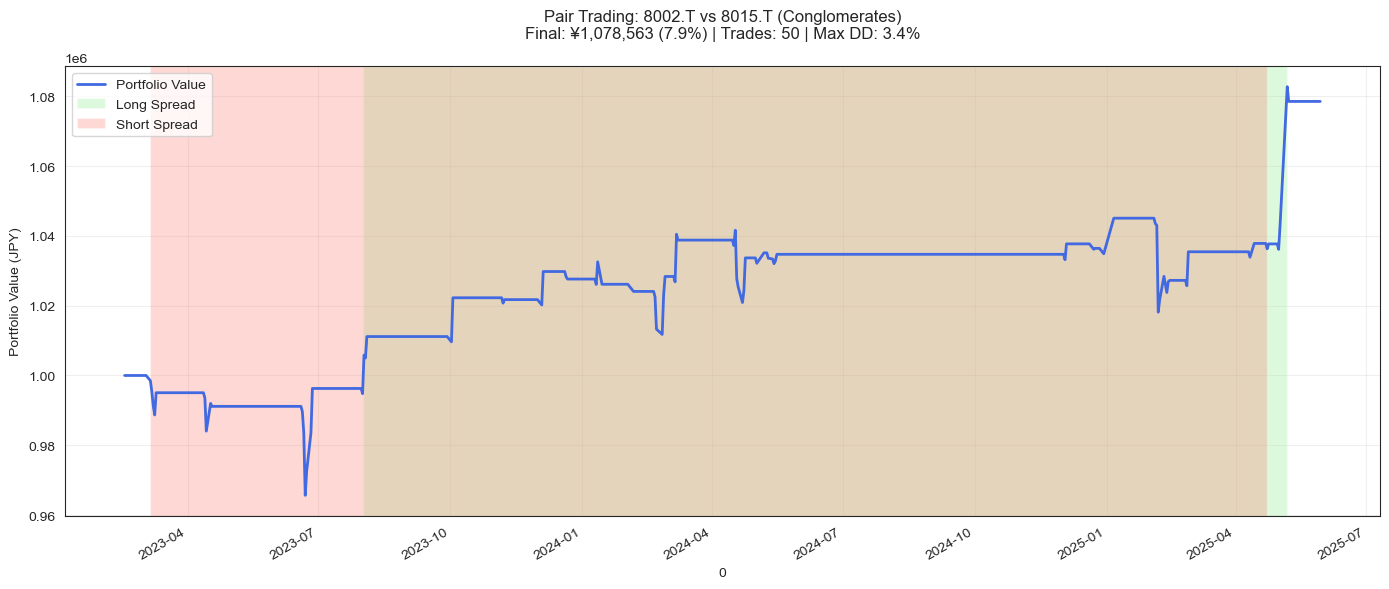

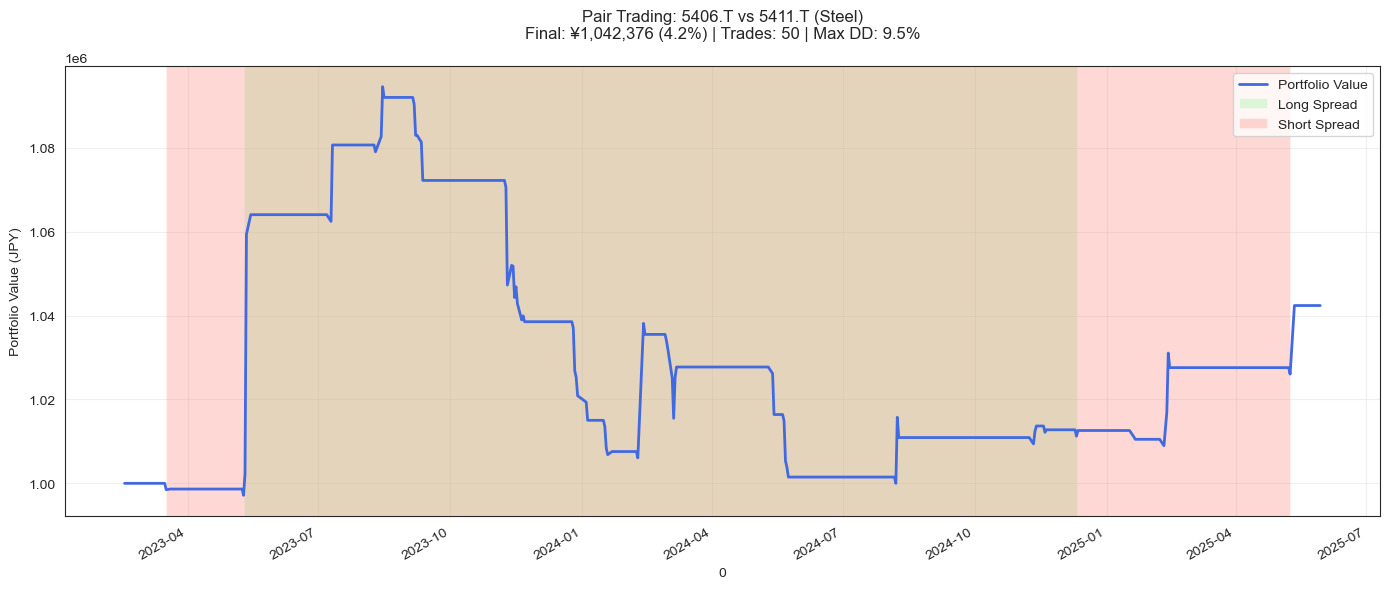

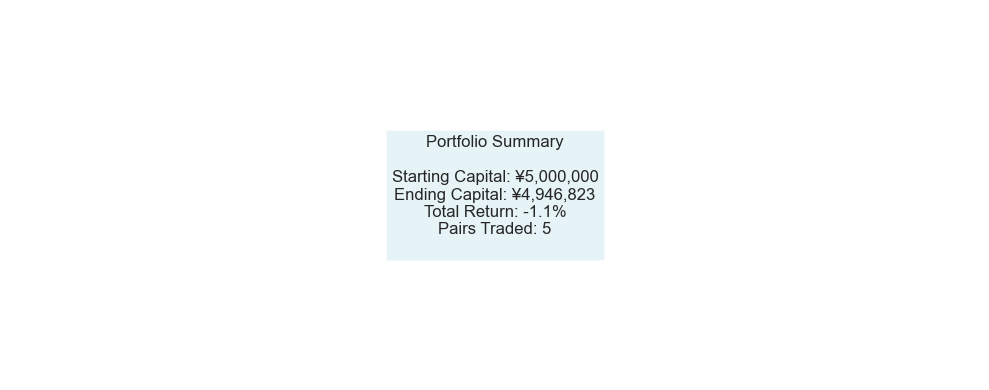

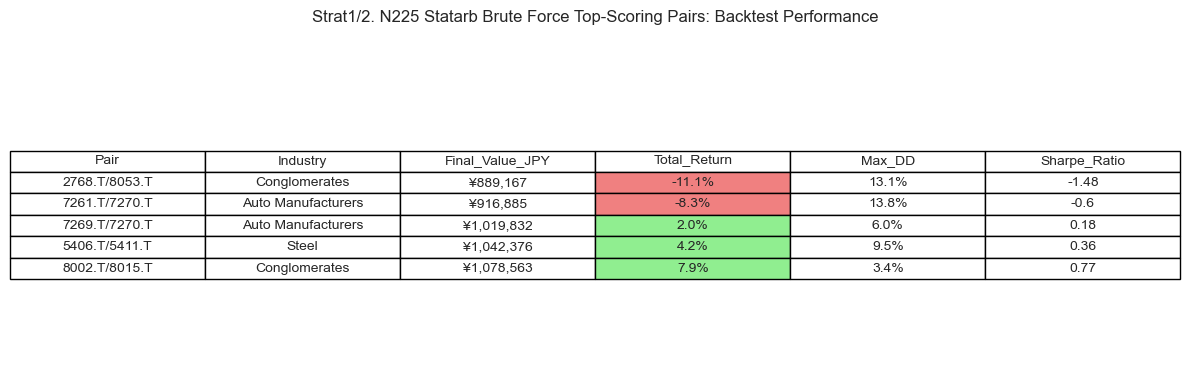

In [36]:
'''
Step2aii. Strat 1/2. N225 Statarb - Brute Force Method - Visualizations
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import os
import pickle

output_dir = "n225_strat1_brute_force"
os.makedirs(output_dir, exist_ok=True)

def generate_visualizations(results_df, portfolios, initial_capital, output_dir="n225_strat1_brute_force"):
    os.makedirs(output_dir, exist_ok=True)
    plt.style.use('default')
    sns.set_style("white")
    rcParams.update({'figure.autolayout': True, 'figure.facecolor': 'white', 'axes.facecolor': 'white'})

    # 1. Individual Pair Performance Charts
    for i, row in results_df.iterrows():
        if i >= len(portfolios):
            break
        pair = row['Pair']
        if '/' in pair:
            ticker1, ticker2 = pair.split('/')
        else:
            ticker1, ticker2 = row['Ticker1'], row['Ticker2']
        portfolio = portfolios[i]
        fig, ax = plt.subplots(figsize=(14, 6))
        portfolio['Value'].plot(ax=ax, color='royalblue', linewidth=2, label='Portfolio Value')
        long_mask = portfolio['Position1'] > 0
        short_mask = portfolio['Position1'] < 0
        if long_mask.any():
            ax.axvspan(portfolio[long_mask].index[0], portfolio[long_mask].index[-1], facecolor='lightgreen', alpha=0.3, label='Long Spread')
        if short_mask.any():
            ax.axvspan(portfolio[short_mask].index[0], portfolio[short_mask].index[-1], facecolor='salmon', alpha=0.3, label='Short Spread')
        ax.set_title(
            f"Pair Trading: {ticker1} vs {ticker2} ({row['Industry']})\n"
            f"Final: ¥{portfolio['Value'].iloc[-1]:,.0f} ({row['Total_Return']:.1%}) | "
            f"Trades: {row['Trades']} | Max DD: {row['Max_DD']:.1%}",
            pad=20)
        ax.set_ylabel('Portfolio Value (JPY)')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"Pair_Performance_{ticker1}_vs_{ticker2}.png"), dpi=300, bbox_inches='tight')
        plt.show()
        #plt.close()

    # 2. Portfolio Summary
    if len(portfolios) > 0:
        total_start = initial_capital * len(portfolios)
        total_end = sum(p['Value'].iloc[-1] for p in portfolios)
        total_return = (total_end - total_start) / total_start
        plt.figure(figsize=(10, 4))
        summary_text = (
            "Portfolio Summary\n\n"
            f"Starting Capital: ¥{total_start:,.0f}\n"
            f"Ending Capital: ¥{total_end:,.0f}\n"
            f"Total Return: {total_return:.1%}\n"
            f"Pairs Traded: {len(portfolios)}\n")
            # f"Avg Return: {results_df['Total_Return'].mean():.1%}")
        plt.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.3))
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, "Portfolio_Summary.png"), dpi=300, bbox_inches='tight')
        plt.show()
        #plt.close()

    # 3. Performance Table
    if len(results_df) > 0:
        # Sort the results_df by Total_Return before creating display_df
        results_df_sorted = results_df.sort_values('Total_Return', ascending=True)
    
        display_df = results_df_sorted[['Pair', 'Industry', 'Final_Value_JPY','Total_Return', 'Max_DD', 'Sharpe_Ratio']].copy()
        display_df['Final_Value_JPY'] = display_df['Final_Value_JPY'].apply(lambda x: f"¥{x:,.0f}")
        display_df['Total_Return'] = display_df['Total_Return'].apply(lambda x: f"{x:.1%}")
        display_df['Max_DD'] = display_df['Max_DD'].apply(lambda x: f"{x:.1%}")
        display_df['Sharpe_Ratio'] = display_df['Sharpe_Ratio'].round(2)
    
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.axis('off')
        table = ax.table(cellText=display_df.values, colLabels=display_df.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
    
        for j in range(1, len(display_df)+1):
            ret = float(display_df.iloc[j-1]['Total_Return'].strip('%'))/100
            table.get_celld()[(j, 3)].set_facecolor('lightgreen' if ret > 0 else 'lightcoral')
    
        plt.title("Strat1/2. N225 Statarb Brute Force Top-Scoring Pairs: Backtest Performance", pad=20)
        plt.savefig(os.path.join(output_dir, "Performance_Table.png"), dpi=300, bbox_inches='tight')
        plt.show()
        #plt.close()

if __name__ == "__main__":
    initial_capital = 1_000_000
    # Explicitly load from n225_strat1_brute_force dir
    results_df = pd.read_csv(os.path.join(output_dir, 'n225_stat_arb_results.csv'))
    with open(os.path.join(output_dir, 'n225_stat_arb_portfolios.pkl'), 'rb') as f:
        portfolios = pickle.load(f)
    generate_visualizations(results_df, portfolios, initial_capital, output_dir=output_dir)

In [37]:
'''
Step2bi. Strat2/2. N225 Statarb - k-Means Clustering
* uses return corrs & k-means clustering to group similar N225 constituent equities.
* selects pairs from within clusters rather than pre-defined industries (used in Strat1) or sectors
* elbow method helps determine optimal cluster count
* maintains identical backtesting params to Strat1 for fair comparison
* remaining logic (cointegration testing, trading signals, position sizing & performance metrics) remains identical to Strat1 above.
* k-means Clustering approach may discover *non-intuitive* pairs that behave similarly despite being from different industries, 
  potentially uncovering new opps the industry-based approach might miss.
'''
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import os
from itertools import combinations
import pickle
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()]

output_dir = "n225_strat2_k-Means"
os.makedirs(output_dir, exist_ok=True)

def kmeans_statarb_strategy(prices_df, metadata_df, initial_capital=1_000_000, transaction_cost=0.0015):
    returns_df = prices_df.pct_change().iloc[-90:].dropna(axis=1)
    tickers = returns_df.columns
    X = returns_df.T.values

    # Determine optimal clusters using Elbow Method
    wcss = []
    for i in tqdm(range(2, 20)):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(range(2, 20), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('# clusters')
    plt.ylabel('WCSS')
    plt.savefig(os.path.join(output_dir, 'elbow_method.png'), bbox_inches='tight', dpi=300)
    plt.close()

    # Based on elbow plot, select K=8 clusters (manually set)
    optimal_k = 8
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(X)
    cluster_assignments = dict(zip(tickers, clusters))

    # Find intra-cluster pairs
    results = []
    for cluster_id in range(optimal_k):
        cluster_tickers = [ticker for ticker, cluster in cluster_assignments.items() if cluster == cluster_id]
        if len(cluster_tickers) < 2:
            continue
        for ticker1, ticker2 in combinations(cluster_tickers, 2):
            try:
                price1 = prices_df[ticker1].iloc[-90:].dropna()
                price2 = prices_df[ticker2].iloc[-90:].dropna()
                common_dates = price1.index.intersection(price2.index)
                if len(common_dates) < 60:
                    continue
                spread = price1[common_dates] - price2[common_dates]
                adf_result = adfuller(spread, autolag="AIC")
                test_stat, pvalue, _, _, critical_values, _ = adf_result
                corr, _ = pearsonr(price1[common_dates], price2[common_dates])
                coint_level = next((level for level, cv in critical_values.items() if test_stat < cv), None)
                results.append({
                    'Cluster': cluster_id, 
                    'Ticker1': ticker1,  'Name1': metadata_df.loc[ticker1, 'Name'],
                    'Ticker2': ticker2,  'Name2': metadata_df.loc[ticker2, 'Name'],
                    'ADF_Stat': test_stat,  'Cointegrated': coint_level,
                    'Corr': corr,  'DataPts': len(common_dates)})
            except Exception as e:
                continue

    # Score & select top pairs 
    results_df = pd.DataFrame(results)
    results_df['Score'] = results_df.apply(
        lambda x: (3 if x['Cointegrated']=='1%' else 
                  2 if x['Cointegrated']=='5%' else 
                  1 if x['Cointegrated']=='10%' else 0) + abs(x['Corr'])*2, axis=1)
    top_pairs = results_df.sort_values('Score', ascending=False).head(5)

    # Backtesting
    portfolios = []
    perf_results = []

    for _, pair in top_pairs.iterrows():
        ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
        price1 = prices_df[ticker1].dropna()
        price2 = prices_df[ticker2].dropna()
        common_idx = price1.index.intersection(price2.index)
        p1, p2 = price1[common_idx], price2[common_idx]
        spread = p1 - p2
        mean_spread = spread.rolling(30).mean()
        std_spread = spread.rolling(30).std()
        zscore = (spread - mean_spread) / std_spread
        signals = pd.Series(0, index=zscore.index)
        signals[zscore > 2.0] = -1
        signals[zscore < -2.0] = 1
        signals[(zscore.abs() < 0.5)] = 0
        signals = signals.ffill().shift()
        capital = initial_capital
        position1, position2 = 0, 0
        portfolio = pd.DataFrame(index=common_idx, columns=['Value', 'Return', 'Position1', 'Position2', 'Cumulative'])
        for date in common_idx[30:]:
            current_signal = signals.loc[date]
            prev_signal = signals.shift(1).loc[date]
            if current_signal != prev_signal:
                if prev_signal != 0:
                    capital += position1 * p1.loc[date] * (1 - transaction_cost)
                    capital += position2 * p2.loc[date] * (1 - transaction_cost)
                    position1, position2 = 0, 0
                if current_signal == 1:
                    position1 = (capital/2) / p1.loc[date]
                    position2 = -(capital/2) / p2.loc[date]
                    capital -= abs(position1 * p1.loc[date] * transaction_cost)
                    capital -= abs(position2 * p2.loc[date] * transaction_cost)
                elif current_signal == -1:
                    position1 = -(capital/2) / p1.loc[date]
                    position2 = (capital/2) / p2.loc[date]
                    capital -= abs(position1 * p1.loc[date] * transaction_cost)
                    capital -= abs(position2 * p2.loc[date] * transaction_cost)
            portfolio.loc[date, 'Value'] = capital + position1 * p1.loc[date] + position2 * p2.loc[date]
            portfolio.loc[date, ['Position1', 'Position2']] = position1, position2
        portfolio['Return'] = portfolio['Value'].pct_change()
        portfolio['Cumulative'] = (1 + portfolio['Return'].fillna(0)).cumprod() * initial_capital
        portfolios.append(portfolio)
        final_value = portfolio['Value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital
        max_drawdown = (portfolio['Value'].cummax() - portfolio['Value']).max() / initial_capital
        perf_results.append({
            'Pair': f"{ticker1}/{ticker2}",
            'Cluster': pair['Cluster'],
            'Final_Value_JPY': final_value,
            'Total_Return': total_return,
            'Ann_Return': (1 + total_return)**(252/len(portfolio)) - 1,
            'Max_DD': max_drawdown,
            'Sharpe_Ratio': portfolio['Return'].mean() / portfolio['Return'].std() * np.sqrt(252),
            'Trades': (signals.diff() != 0).sum(),
            'Coint_Level': pair['Cointegrated'],
            'Corr': pair['Corr']})

    # Save results for later visualization
    results_df_save = pd.DataFrame(perf_results)
    results_df_save.to_csv(os.path.join(output_dir, 'n225_kmeans_stat_arb_results.csv'), index=False)
    with open(os.path.join(output_dir, 'n225_kmeans_stat_arb_portfolios.pkl'), 'wb') as f:
        pickle.dump(portfolios, f)
    with open(os.path.join(output_dir, 'n225_kmeans_stat_arb_top_pairs.pkl'), 'wb') as f:
        pickle.dump(top_pairs, f)

    print("\nBacktest results saved in", output_dir)

if __name__ == "__main__":
    kmeans_statarb_strategy(prices_df, metadata_df)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 18.91it/s]



Backtest results saved in n225_strat2_k-Means


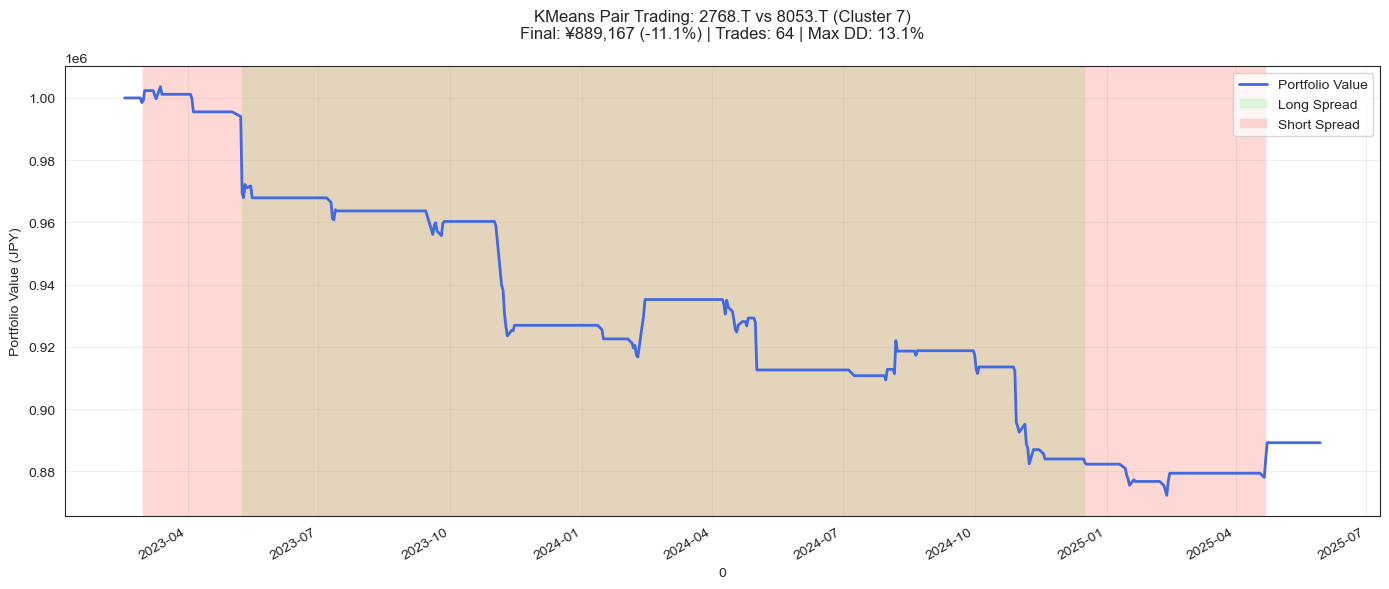

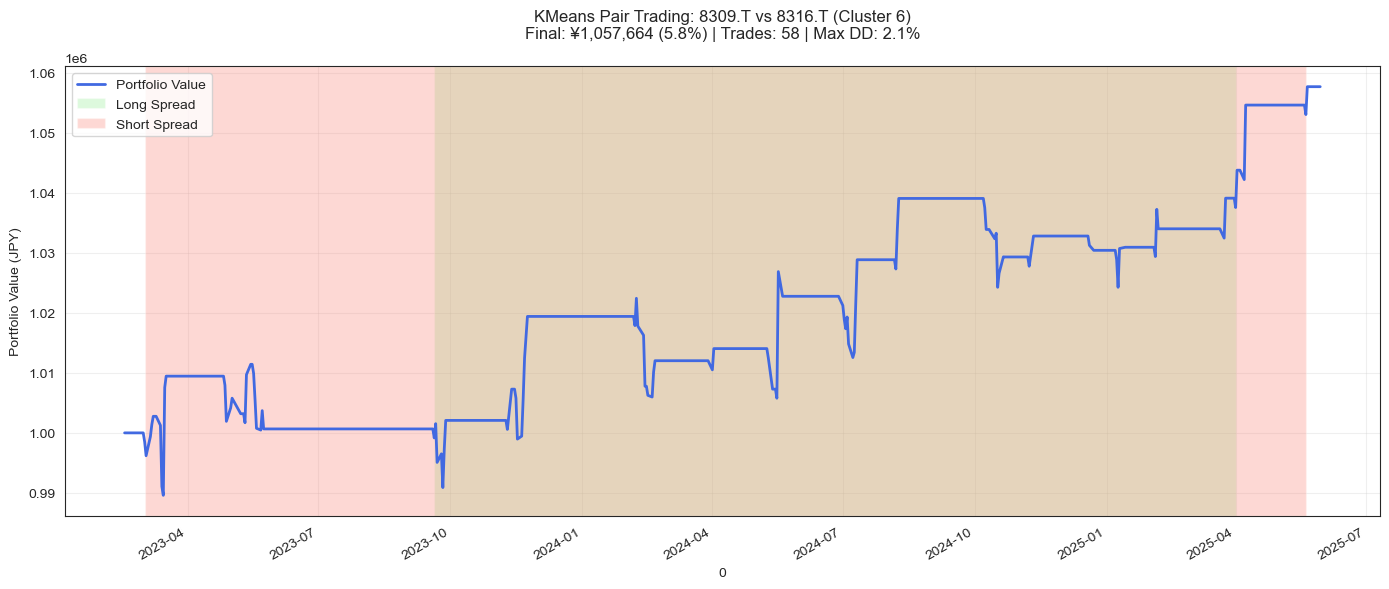

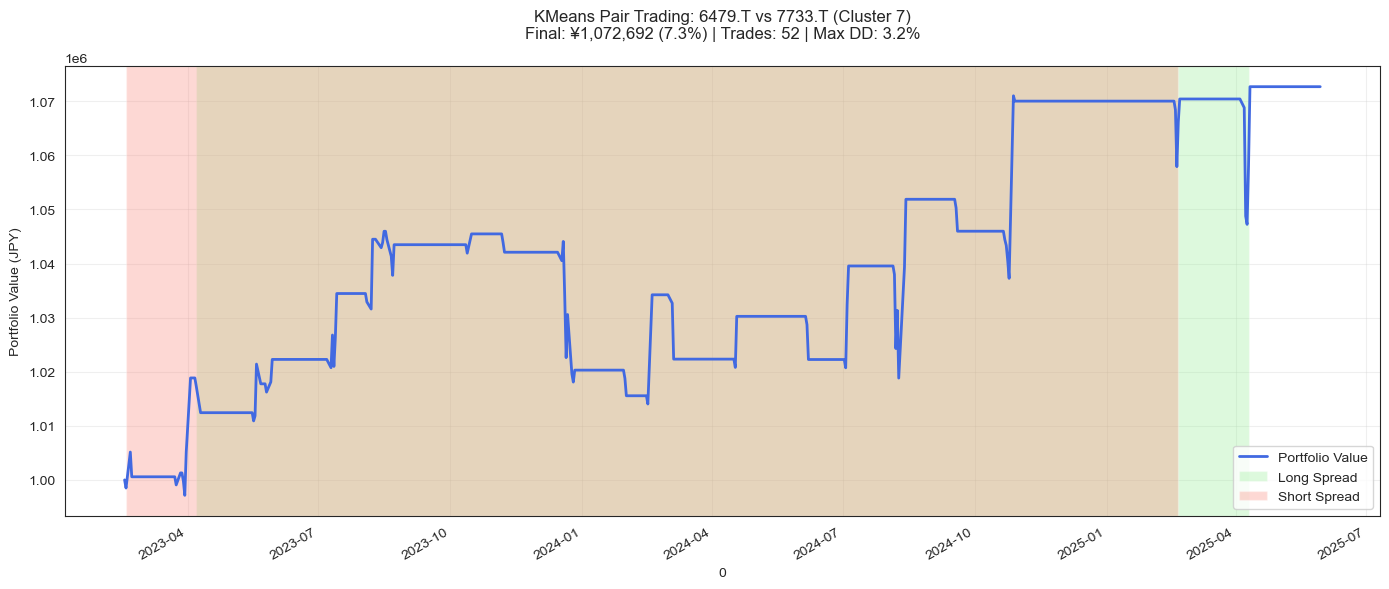

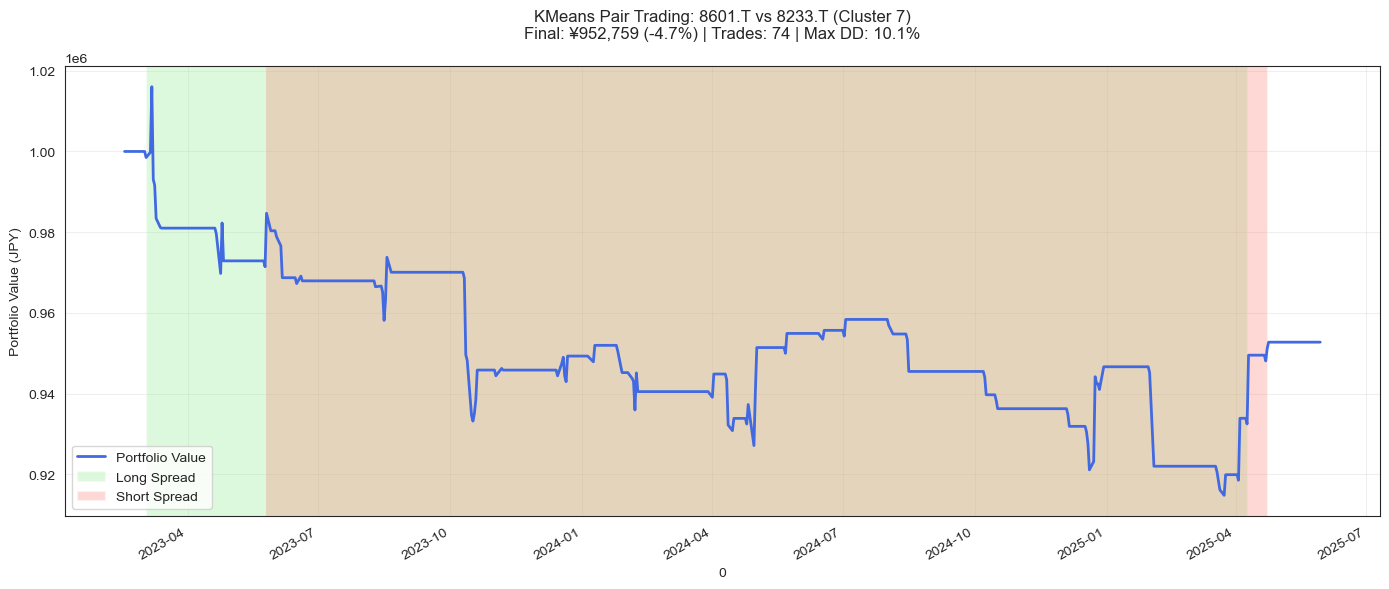

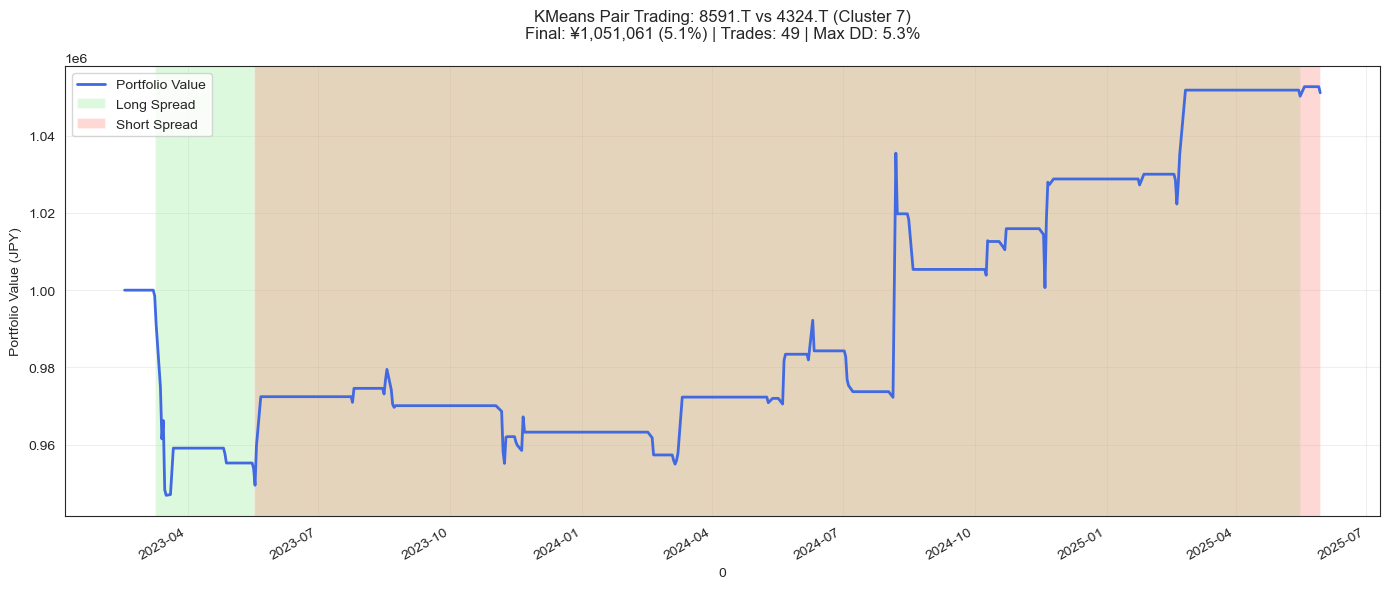

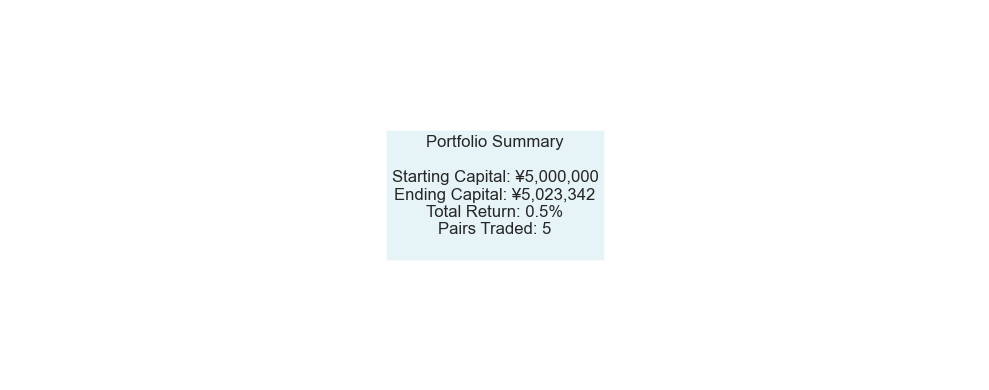

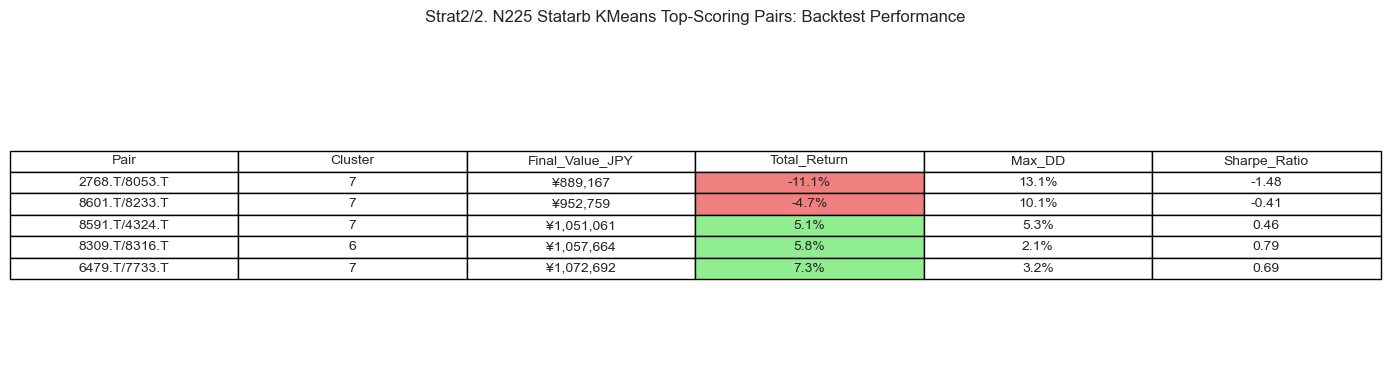

In [38]:
'''
Step2bii. Strat2/2. N225 Statarb - k-Means Clustering - Visualizations
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import os
import pickle

output_dir = "n225_strat2_k-Means"
os.makedirs(output_dir, exist_ok=True)

def generate_visualizations(results_df, portfolios, initial_capital, output_dir="n225_strat2_k-Means"):
    os.makedirs(output_dir, exist_ok=True)
    plt.style.use('default')
    sns.set_style("white")
    rcParams.update({'figure.autolayout': True, 'figure.facecolor': 'white', 'axes.facecolor': 'white'})

    # 1. Indv Pair Performance Charts
    for i, row in results_df.iterrows():
        if i >= len(portfolios):
            break
        pair = row['Pair']
        cluster = row['Cluster']
        if '/' in pair:
            ticker1, ticker2 = pair.split('/')
        else:
            ticker1, ticker2 = row['Ticker1'], row['Ticker2']
        portfolio = portfolios[i]
        fig, ax = plt.subplots(figsize=(14, 6))
        portfolio['Value'].plot(ax=ax, color='royalblue', linewidth=2, label='Portfolio Value')
        long_mask = portfolio['Position1'] > 0
        short_mask = portfolio['Position1'] < 0
        if long_mask.any():
            ax.axvspan(portfolio[long_mask].index[0], portfolio[long_mask].index[-1], facecolor='lightgreen', alpha=0.3, label='Long Spread')
        if short_mask.any():
            ax.axvspan(portfolio[short_mask].index[0], portfolio[short_mask].index[-1], facecolor='salmon', alpha=0.3, label='Short Spread')
        ax.set_title(f"KMeans Pair Trading: {ticker1} vs {ticker2} (Cluster {cluster})\n"
            f"Final: ¥{portfolio['Value'].iloc[-1]:,.0f} ({row['Total_Return']:.1%}) | "
            f"Trades: {row['Trades']} | Max DD: {row['Max_DD']:.1%}", pad=20)
        ax.set_ylabel('Portfolio Value (JPY)')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"KMeans_Pair_Performance_{cluster}_{ticker1}_vs_{ticker2}.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # 2. Portfolio Summary
    if len(portfolios) > 0:
        total_start = initial_capital * len(portfolios)
        total_end = sum(p['Value'].iloc[-1] for p in portfolios)
        total_return = (total_end - total_start) / total_start
        plt.figure(figsize=(10, 4))
        summary_text = (
            "Portfolio Summary\n\n"
            f"Starting Capital: ¥{total_start:,.0f}\n"
            f"Ending Capital: ¥{total_end:,.0f}\n"
            f"Total Return: {total_return:.1%}\n"
            f"Pairs Traded: {len(portfolios)}\n")
            # f"Avg Return: {results_df['Total_Return'].mean():.1%}")
        plt.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.3))
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, "KMeans_Portfolio_Summary.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

         # 3. Performance Table
    if len(results_df) > 0:
        # Sort the results_df by Total_Return before creating display_df
        results_df_sorted = results_df.sort_values('Total_Return', ascending=True)
    
        display_df = results_df_sorted[['Pair', 'Cluster', 'Final_Value_JPY', 'Total_Return', 'Max_DD', 'Sharpe_Ratio']].copy()
        display_df['Final_Value_JPY'] = display_df['Final_Value_JPY'].apply(lambda x: f"¥{x:,.0f}")
        display_df['Total_Return'] = display_df['Total_Return'].apply(lambda x: f"{x:.1%}")
        display_df['Max_DD'] = display_df['Max_DD'].apply(lambda x: f"{x:.1%}")
        display_df['Sharpe_Ratio'] = display_df['Sharpe_Ratio'].round(2)
    
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.axis('off')
        table = ax.table(cellText=display_df.values, colLabels=display_df.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
    
        for j in range(1, len(display_df)+1):
            ret = float(display_df.iloc[j-1]['Total_Return'].strip('%'))/100
            table.get_celld()[(j, 3)].set_facecolor('lightgreen' if ret > 0 else 'lightcoral')
    
        plt.title("Strat2/2. N225 Statarb KMeans Top-Scoring Pairs: Backtest Performance", pad=20)
        plt.savefig(os.path.join(output_dir, "KMeans_Performance_Table.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

if __name__ == "__main__":
    initial_capital = 1_000_000
    results_df = pd.read_csv(os.path.join(output_dir, 'n225_kmeans_stat_arb_results.csv'))
    with open(os.path.join(output_dir, 'n225_kmeans_stat_arb_portfolios.pkl'), 'rb') as f:
        portfolios = pickle.load(f)
    generate_visualizations(results_df, portfolios, initial_capital, output_dir=output_dir)